# Analytics for ticket service website <a class="tocSkip">
## Project description <a class="tocSkip">

It is necessary to analyze how people use the product, when they start buying tickets, how much money each customer brings in and when the customer pays off. The analysis is based on data on website visits, orders and statistics on marketing costs.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats.mstats as mstats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.options.display.float_format = '{: .2f}'.format
sns.set_style('darkgrid')

## Data preprocessing <a id="1"></a>   
</div>

### `Visits` data

In [3]:
visits = pd.read_csv('datasets/visits_log.csv')
visits.info()
visits.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Device               End Ts  Source Id             Start Ts  \
303980  desktop  2018-04-11 12:31:00          3  2018-04-11 12:31:00   
358812    touch  2018-01-08 17:38:19          1  2018-01-08 17:38:00   
48775   desktop  2018-01-07 03:27:00          4  2018-01-07 03:24:00   
136169    touch  2018-02-10 10:06:00          4  2018-02-10 09:46:00   
145863  desktop  2018-04-13 23:40:00          4  2018-04-13 23:37:00   

                         Uid  
303980   1428739586779524427  
358812   5648713009464508381  
48775   16893604039595149150  
136169  17361456347652348650  
145863   4404188115107056900

Column `Source Id` presents data on marketing source id.

In [4]:
print('Number of duplicates:', visits.duplicated().sum())

Number of duplicates: 0


In [5]:
visits.columns = (
    visits
    .columns.str.lower()
    .str.replace(' ', '_')
)

visits.columns

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

In [6]:
print('Types of devices:', visits['device'].unique())
print('Sources (marketing):', visits['source_id'].unique())

Types of devices: ['touch' 'desktop']
Sources (marketing): [ 4  2  5  9  3  1 10  7  6]


In [7]:
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits['end_ts'] = pd.to_datetime(visits['end_ts'])

visits.dtypes

device               object
end_ts       datetime64[ns]
source_id             int64
start_ts     datetime64[ns]
uid                  uint64
dtype: object

In [8]:
visits['start_ts'].describe(datetime_is_numeric=True)

count                           359400
mean     2017-12-18 06:17:32.010517760
min                2017-06-01 00:01:00
25%                2017-10-15 09:41:00
50%                2017-12-18 18:46:00
75%                2018-02-28 09:54:00
max                2018-05-31 23:59:00
Name: start_ts, dtype: object

In [9]:
visits['end_ts'].describe(datetime_is_numeric=True)

count                           359400
mean     2017-12-18 06:28:15.036205056
min                2017-06-01 00:02:00
25%                2017-10-15 09:45:45
50%                2017-12-18 18:59:30
75%                2018-02-28 10:08:15
max                2018-06-01 01:26:00
Name: end_ts, dtype: object

If there are sessions of zero duration in the dataset, they must be removed. Zero duration of a session is possible if the user had closed the page before it loaded.

In [10]:
visits['duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
print('Number of sessions of zero duration: ', len(visits[visits['duration'] == 0]))

Number of sessions of zero duration:  35794


In [11]:
visits = visits[visits['duration'] != 0].copy()
visits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323606 entries, 0 to 359399
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     323606 non-null  object        
 1   end_ts     323606 non-null  datetime64[ns]
 2   source_id  323606 non-null  int64         
 3   start_ts   323606 non-null  datetime64[ns]
 4   uid        323606 non-null  uint64        
 5   duration   323606 non-null  int64         
dtypes: datetime64[ns](2), int64(2), object(1), uint64(1)
memory usage: 17.3+ MB


Sessions of zero duration have been removed. There are 323,606 entries left in the table. Let's analyze the duration of the remaining sessions.

In [12]:
visits['duration'].describe()

count    323606.00
mean        714.68
std        1047.05
min          19.00
25%         120.00
50%         360.00
75%         900.00
max       84480.00
Name: duration, dtype: float64

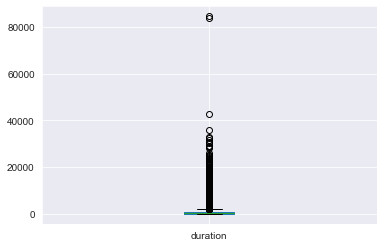

In [13]:
visits.boxplot('duration')
plt.show()

The dataset contains sessions of a very long duration (several hours). At the same time, 75% of sessions have a duration of up to 15 minutes. Data for very long sessions may be erroneous. Let's estimate the number of sessions of a duration of more than an hour.

In [14]:
print('Number of sessions of a duration of more than an hour', len(visits[visits['duration'] > 3600]))
print('Share of sessions of a duration of more than an hour {:.1%}'.format(
    len(visits[visits['duration'] > 3600])/len(visits)))

Number of sessions of a duration of more than an hour 6284
Share of sessions of a duration of more than an hour 1.9%


Let's delete sessions with a duration of more than 1 hour.

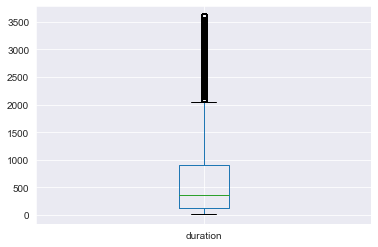

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317322 entries, 0 to 359399
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     317322 non-null  object        
 1   end_ts     317322 non-null  datetime64[ns]
 2   source_id  317322 non-null  int64         
 3   start_ts   317322 non-null  datetime64[ns]
 4   uid        317322 non-null  uint64        
 5   duration   317322 non-null  int64         
dtypes: datetime64[ns](2), int64(2), object(1), uint64(1)
memory usage: 16.9+ MB


In [15]:
visits = visits[visits['duration'] <= 3600].copy()
visits.boxplot('duration')
plt.show()
visits.info()

Sessions longer than 1 hour have been removed. There are 317,322 observations left in the dataset.

Let's add a visit_id column to the table for the convenience of working with several tables.

In [16]:
visits['visit_id'] = range(0, len(visits))
visits.sample(5)

device              end_ts  source_id            start_ts  \
294453  desktop 2017-07-16 02:26:00          3 2017-07-16 02:16:00   
225190  desktop 2018-04-23 18:52:00          1 2018-04-23 18:51:00   
126554  desktop 2017-11-01 11:56:00          1 2017-11-01 11:16:00   
200314  desktop 2018-01-14 14:29:00          3 2018-01-14 14:17:00   
10335   desktop 2018-05-23 14:13:00          3 2018-05-23 13:20:00   

                         uid  duration  visit_id  
294453  11924770371159983871       600    259745  
225190   5431268286018174802        60    198671  
126554  10928771694821180183      2400    111592  
200314   5497123329621215676       720    176743  
10335   11622537527581388734      3180      9112

### `Orders` data

In [17]:
orders = pd.read_csv('datasets/orders_log.csv')
orders.info()
orders.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Buy Ts  Revenue                   Uid
28274  2018-01-05 22:36:00     6.42   5467304878656346452
27124  2017-12-30 10:57:00     1.47  16465672938767168507
46638  2018-05-07 19:32:00    34.22  12482573044977719334
30414  2018-01-22 09:32:00     1.22   1884031971226658346
12062  2017-10-10 20:49:00     4.28  15593804536758364411

In [18]:
print('Number of duplicates:', orders.duplicated().sum())

Number of duplicates: 0


In [19]:
orders.columns = (
    orders
    .columns.str.lower()
    .str.replace(' ', '_')
)

orders.columns

Index(['buy_ts', 'revenue', 'uid'], dtype='object')

In [20]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

orders.dtypes

buy_ts     datetime64[ns]
revenue           float64
uid                uint64
dtype: object

In [21]:
orders['buy_ts'].describe(datetime_is_numeric=True)

count                            50415
mean     2017-12-20 05:14:24.846176768
min                2017-06-01 00:10:00
25%                2017-10-13 17:28:00
50%                2017-12-21 14:12:00
75%                2018-03-02 16:10:00
max                2018-06-01 00:02:00
Name: buy_ts, dtype: object

Let's examine the distribution of revenue from orders.

In [22]:
orders['revenue'].describe()

count    50415.00
mean         5.00
std         21.82
min          0.00
25%          1.22
50%          2.50
75%          4.89
max       2633.28
Name: revenue, dtype: float64

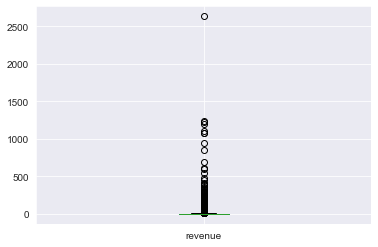

In [23]:
orders.boxplot('revenue')
plt.show()

The analysis has shown the presence of outliers: for 75% of orders the amount of revenue does not exceed 4.89, but there are orders for which the revenue is 2633.28. While the existence of very expensive or large orders is possible, the presence of such data can skew the analysis. Let's estimate the number of orders, the revenue for which amounted to more than 50. 

In [24]:
print('Number of orders with revenue > 50: ', len(orders[orders['revenue'] > 50]))

Number of orders with revenue > 50:  308


Let's delete the rows with orders, the revenue for which was more than 50.

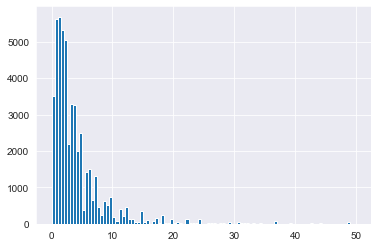

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50107 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50107 non-null  datetime64[ns]
 1   revenue  50107 non-null  float64       
 2   uid      50107 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.5 MB


In [25]:
orders = orders[orders['revenue'] <= 50].copy()
orders['revenue'].hist(bins=100)
plt.show()
orders.info()

Data on orders that are too expensive has been removed. There are 50107 observations left in the dataframe.

Let's add the *order_id* column to the dataframe for the convenience of working with several dataframes.

In [26]:
orders['order_id'] = range(0, len(orders))
display(orders.sample(5))

buy_ts  revenue                   uid  order_id
50261 2018-05-31 17:24:00     2.75   8082156923213970958     49954
8936  2017-09-25 09:37:00     6.11  16716672022824920124      8895
5600  2017-08-18 20:01:00     7.33   6191771385018069863      5582
4358  2017-07-25 10:12:00     2.14  11139335992356361566      4341
6687  2017-09-02 22:09:00     4.89  16045286664831274288      6663

### `Costs` data 
(marketing spending information)

In [27]:
costs = pd.read_csv('datasets/costs.csv')

display(costs.sample(5))

source_id          dt   costs
2012          9  2017-12-14   17.03
1             1  2017-06-02   62.25
953           3  2018-01-14  502.70
531           2  2017-11-16  272.25
1081          3  2018-05-24  352.08

In [28]:
costs.info()
print('Number of duplicates:', costs.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
Number of duplicates: 0


In [29]:
costs['dt'] = pd.to_datetime(costs['dt'])

costs.dtypes

source_id             int64
dt           datetime64[ns]
costs               float64
dtype: object

In [30]:
costs['dt'].describe(datetime_is_numeric=True)

count                             2542
mean     2017-11-29 09:04:57.403619072
min                2017-06-01 00:00:00
25%                2017-08-30 00:00:00
50%                2017-11-29 00:00:00
75%                2018-02-28 00:00:00
max                2018-05-31 00:00:00
Name: dt, dtype: object

In [31]:
print('Sources (marketing):', costs['source_id'].unique())

Sources (marketing): [ 1  2  3  4  5  9 10]


The marketing source IDs in the `costs` dataframe do not match the marketing source IDs in the `visits` table. Since we are analyzing data to optimize marketing costs, we are only interested in the sessions associated with sources in the `costs` dataframe.

Let's go back to the `visits` dataframe and delete the sessions with origins 6 and 7.

In [32]:
print('Number of sessions from sources 6 и 7: ', len(visits.query('source_id == 6 or source_id == 7')))

Number of sessions from sources 6 и 7:  38


In [33]:
visits = visits[(visits['source_id']!=6) & (visits['source_id']!=7)].copy()
visits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317284 entries, 0 to 359399
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     317284 non-null  object        
 1   end_ts     317284 non-null  datetime64[ns]
 2   source_id  317284 non-null  int64         
 3   start_ts   317284 non-null  datetime64[ns]
 4   uid        317284 non-null  uint64        
 5   duration   317284 non-null  int64         
 6   visit_id   317284 non-null  int64         
dtypes: datetime64[ns](2), int64(3), object(1), uint64(1)
memory usage: 19.4+ MB


Sessions with sources 6 and 7 are removed from the dataset. There are 317,284 values left in the `visits` table.

In [34]:
print('Marketing sources in visists dataframe:', visits['source_id'].unique())

Marketing sources in visists dataframe: [ 4  2  9  5  1  3 10]


## Data analysis<a id="2"></a>   
</div>

As part of the analysis, it is necessary to build reports and calculate metrics, as well as display on graphs how these metrics differ by device and marketing source and how they change over time.

Let's save the corresponding lists in variables.

In [35]:
devices = ['touch', 'desktop']
sources = [1,  2,  3,  4,  5,  9, 10]

### Product<a id="2.1"></a>   
</div>

Let's analyze the data in the `visits` dataframe.

Let's explore user activity in three dimensions:
* **DAU** (*daily active users*) - the number of unique users per day;
* **WAU** (*weekly active users*) - the number of unique users per week;
* **MAU** (*monthly active users*) - the number of unique users per month.

All indicators are calculated for each month of the year.

Since the same user can access the website from different devices and come from different advertising sources, we cannot calculate all the indicators we are interested in in one pivot table. Therefore, we will create separate tables to assess user activity by device and advertising sources. 

First, let's calculate the metrics for all users.

Number of unique users


dau   wau    mau
visit_month                   
2017-06       451  2538  11825
2017-07       473  2273  12671
2017-08       386  2243  10421
2017-09       658  3682  17026
2017-10      1009  4855  26623
2017-11      1181  6484  29433
2017-12      1103  6236  28282
2018-01       975  5585  25709
2018-02      1086  5630  25802
2018-03       937  5380  24663
2018-04       749  4023  18713
2018-05       696  4003  18429

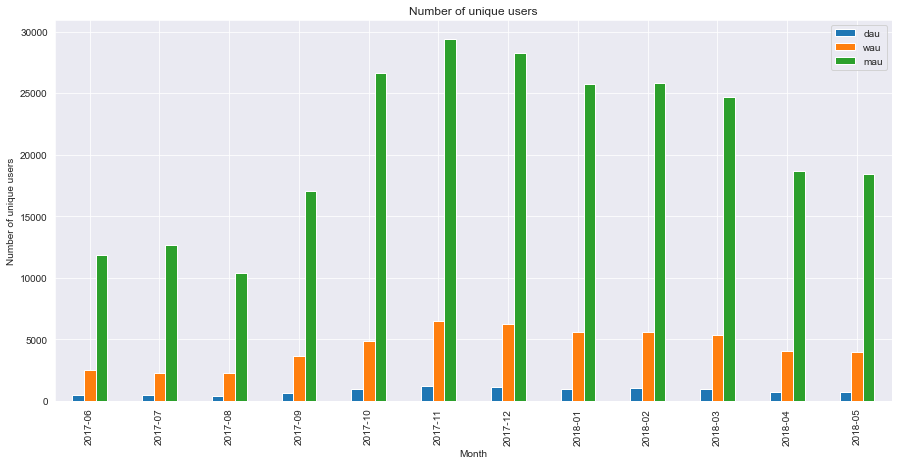

Number of unique users


dau   wau   mau
visit_month                  
2017-06       NaN   NaN   NaN
2017-07      0.05 -0.10  0.07
2017-08     -0.18 -0.01 -0.18
2017-09      0.70  0.64  0.63
2017-10      0.53  0.32  0.56
2017-11      0.17  0.34  0.11
2017-12     -0.07 -0.04 -0.04
2018-01     -0.12 -0.10 -0.09
2018-02      0.11  0.01  0.00
2018-03     -0.14 -0.04 -0.04
2018-04     -0.20 -0.25 -0.24
2018-05     -0.07 -0.00 -0.02

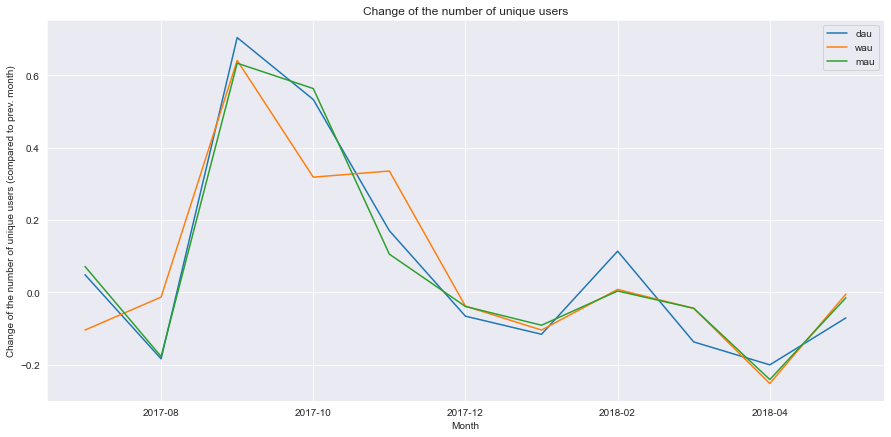

In [36]:
visits['visit_month'] = visits['start_ts'].astype('datetime64[M]').dt.strftime('%Y-%m')
visits['week']  = visits['start_ts'].dt.isocalendar().week
visits['date'] = visits['start_ts'].dt.date

dau = (
    (
    visits
    .groupby(['visit_month', 'date'])
    .agg({'uid': 'nunique'})
    )
    .groupby(['visit_month'])
    .agg({'uid': 'mean'})
    .rename(columns={"uid": "dau"})
)
dau['dau'] = dau['dau'].astype('int')

wau = (
    (
    visits
    .groupby(['visit_month', 'week'])
    .agg({'uid': 'nunique'})
    )
    .groupby(['visit_month'])
    .agg({'uid': 'mean'})
    .rename(columns={"uid": "wau"})
)
wau['wau'] = wau['wau'].astype('int')

mau = (
    visits
    .groupby('visit_month')
    .agg({'uid': 'nunique'})
    .rename(columns={"uid": "mau"})
    )

au = pd.merge(pd.merge(dau, wau, how='left', on='visit_month'), mau, how='left', on='visit_month')

print('Number of unique users')
display(au)

au.plot(kind='bar', figsize=(15, 7))
plt.title('Number of unique users')
plt.xlabel('Month')
plt.ylabel('Number of unique users')
plt.show()

print('Number of unique users')
au_pct = au.pct_change()
display(au_pct)

au_pct.plot(kind='line', figsize=(15, 7))
plt.title('Change of the number of unique users')
plt.xlabel('Month')
plt.ylabel('Change of the number of unique users (compared to prev. month)')
plt.show()

The number of unique users of the website per day, week, or month is highly dependent on the season. The number of unique users per day varies depending on the season from 451 (June) to 1181 (November), the number of unique users per week - from 2538 (June) to 6484 (November), the number of unique users per month - from 11825 (June) to 29433 (November).

Due to the presence of pronounced seasonality, it is difficult to judge whether user activity has increased over the analyzed period. At the same time, the number of unique users at the end of the period (May 2018) significantly exceeds the number of users at the beginning of the period (June 2017): the number of unique users per month increased from 11,825 to 18,429, which suggests an increase in user activity.

Let's explore the dynamics of user activity indicators depending on the devices they use.

Number of unique users by device type


dau   wau    mau  dau_touch  wau_touch  mau_touch  dau_desktop  \
visit_month                                                                    
2017-06       451  2538  11825        114        664       3181          338   
2017-07       473  2273  12671        130        642       3677          345   
2017-08       386  2243  10421         94        567       2726          292   
2017-09       658  3682  17026        181       1041       4968          479   
2017-10      1009  4855  26623        281       1384       7788          732   
2017-11      1181  6484  29433        299       1681       7858          888   
2017-12      1103  6236  28282        287       1655       7688          820   
2018-01       975  5585  25709        276       1624       7672          700   
2018-02      1086  5630  25802        298       1595       7511          791   
2018-03       937  5380  24663        271       1545       7311          678   
2018-04       749  4023  18713        207       1150       5530          544   
2018-05       696  4003  18429        206       1222       5803          492   

             wau_desktop  mau_desktop  
visit_month                            
2017-06             1891         8776  
2017-07             1647         9153  
2017-08             1687         7794  
2017-09             2664        12238  
2017-10             3513        19227  
2017-11             4869        22060  
2017-12             4638        21029  
2018-01             3997        18358  
2018-02             4080        18660  
2018-03             3876        17697  
2018-04             2898        13378  
2018-05             2810        12848

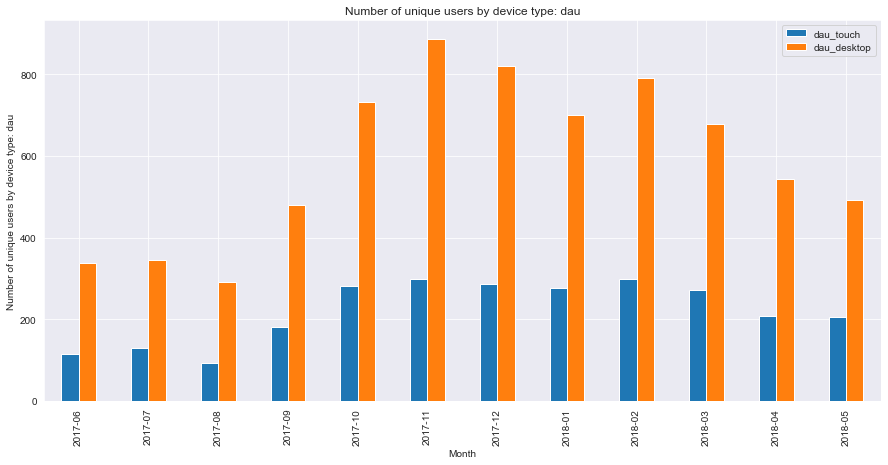

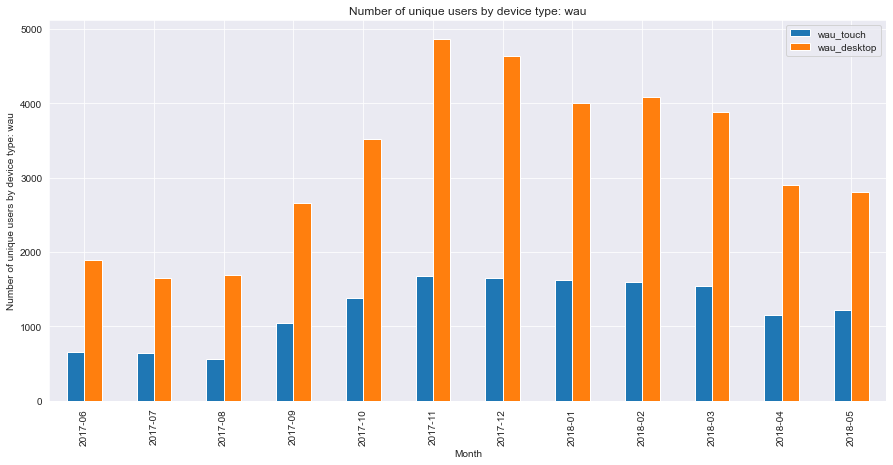

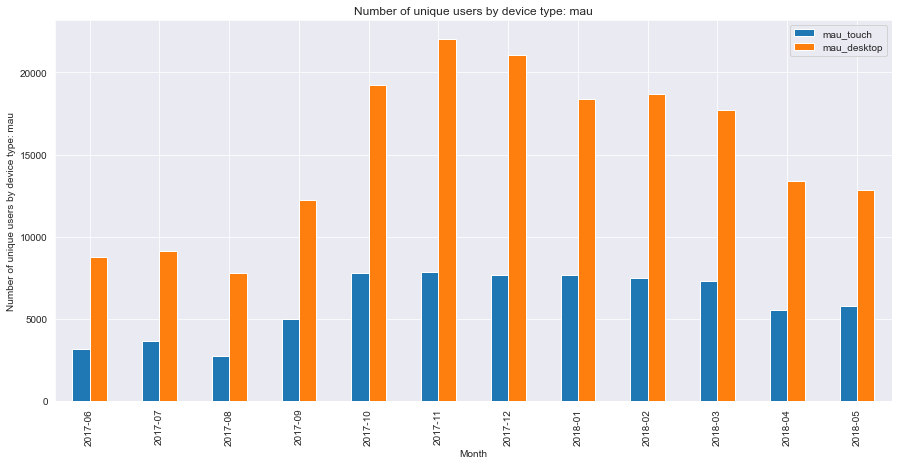

In [37]:
au_devices = au

for device in devices:
    dau = (
        (
        visits[visits['device'] == device]
        .groupby(['visit_month', 'date'])
        .agg({'uid': 'nunique'})
        )
        .groupby(['visit_month'])
        .agg({'uid': 'mean'})
        .rename(columns={"uid": "dau"})
    )
    dau['dau'] = dau['dau'].astype('int')

    wau = (
        (
        visits[visits['device'] == device]
        .groupby(['visit_month', 'week'])
        .agg({'uid': 'nunique'})
        )
        .groupby(['visit_month'])
        .agg({'uid': 'mean'})
        .rename(columns={"uid": "wau"})
    )
    wau['wau'] = wau['wau'].astype('int')

    mau = (
        visits[visits['device'] == device]
        .groupby('visit_month')
        .agg({'uid': 'nunique'})
        .rename(columns={"uid": "mau"})
        )

    au_device = pd.merge(pd.merge(dau, wau, how='left', on='visit_month'), mau, how='left', on='visit_month')
    au_device = au_device.add_suffix('_')
    au_device = au_device.add_suffix(device)
    au_devices = pd.merge(au_devices, au_device, how='left', on='visit_month')

print('Number of unique users by device type')
display(au_devices)

for metric in ("dau", "wau", "mau"):
    au_devices.loc[:, au_devices.columns.str.startswith(metric+'_')].plot(kind='bar', figsize=(15, 7))
    plt.title('Number of unique users by device type: {}'.format(metric))
    plt.xlabel('Month')
    plt.ylabel('Number of unique users by device type: {}'.format(metric))
    plt.show()

The number of unique users accessing the website from desktop devices is more than twice the number of unique users accessing the site from touch devices. The dynamics of the number of unique users from devices of different types is similar.

Let's analyze user activity denepending on marketing source.

Number of unique users by marketing source: dau


dau_1  dau_2  dau_3  dau_4  dau_5  dau_9  dau_10
visit_month                                                  
2017-06         40     58    128    113     88     23      13
2017-07         41     65    120    124    110     18       9
2017-08         32     49    101     93     93     19       7
2017-09         57     84    178    167    154     25      15
2017-10         85    126    253    294    225     33      27
2017-11        114    165    312    360    203     48      29
2017-12        110    146    274    367    188     39      19
2018-01         83    122    251    313    173     33      32
2018-02         95    134    287    331    200     35      40
2018-03         87    128    235    308    144     60      38
2018-04         68     98    173    234    159     24      18
2018-05         67    109    158    217    124     23      23

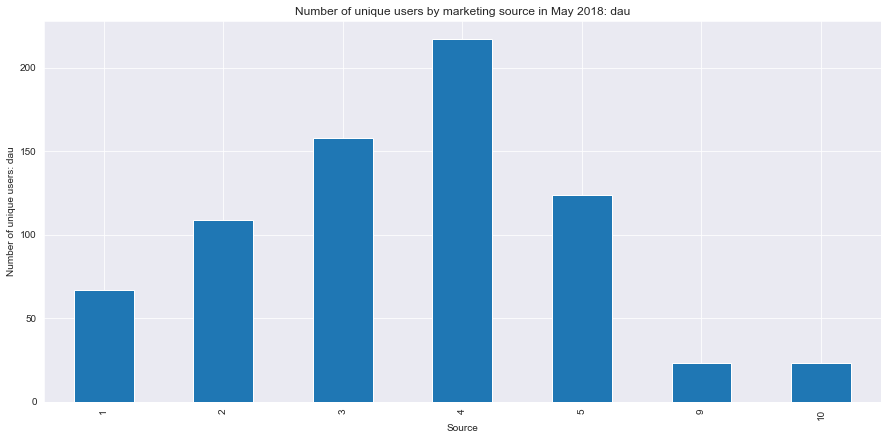

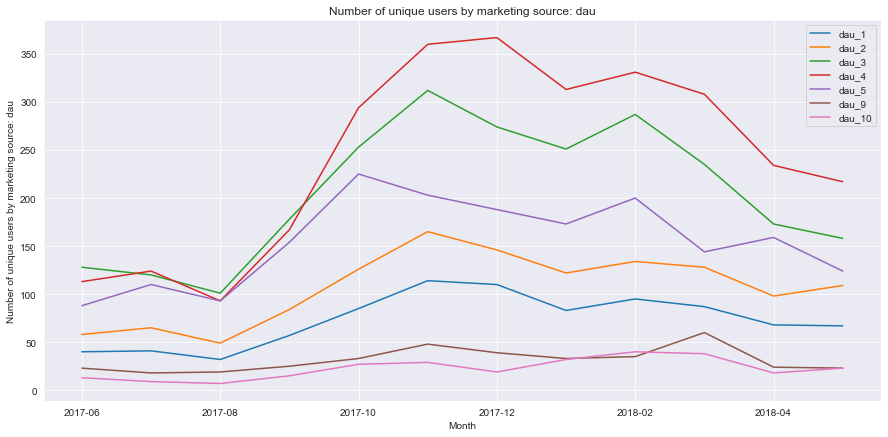

Number of unique users by marketing source: wau


wau_1  wau_2  wau_3  wau_4  wau_5  wau_9  wau_10
visit_month                                                  
2017-06        202    319    759    663    525    140      80
2017-07        182    296    614    629    555     91      49
2017-08        168    266    622    573    570    120      46
2017-09        295    452   1055    983    897    150      89
2017-10        381    591   1290   1482   1135    166     140
2017-11        585    870   1844   2087   1188    284     164
2017-12        577    786   1670   2199   1134    238     113
2018-01        444    660   1537   1890   1049    202     174
2018-02        452    665   1584   1812   1088    193     205
2018-03        472    691   1387   1809    845    349     214
2018-04        336    498    987   1325    900    139     106
2018-05        365    603    967   1322    745    140     142

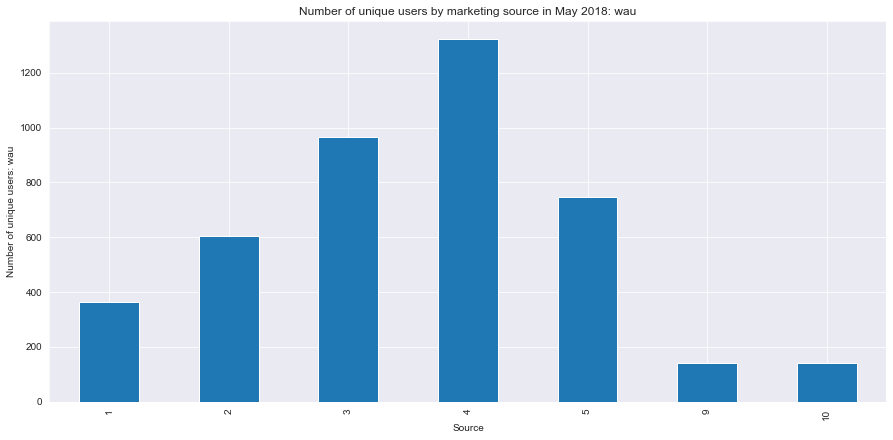

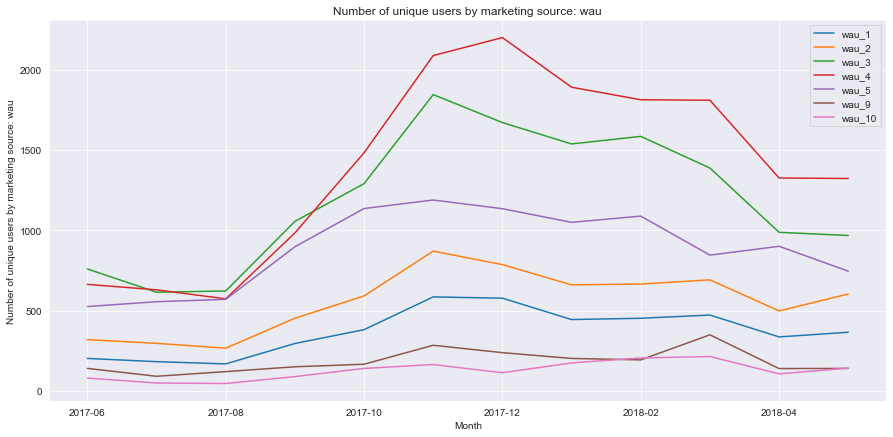

Number of unique users by marketing source: mau


mau_1  mau_2  mau_3  mau_4  mau_5  mau_9  mau_10
visit_month                                                  
2017-06        895   1376   3732   3223   2579    659     389
2017-07        979   1581   3600   3668   3260    512     293
2017-08        731   1128   3043   2799   2790    563     227
2017-09       1315   1960   5184   4758   4357    706     440
2017-10       2011   3069   7567   8510   6628    932     817
2017-11       2584   3794   9005   9953   5769   1347     791
2017-12       2533   3322   8160  10477   5493   1095     534
2018-01       1998   2861   7522   9085   5105    949     818
2018-02       1976   2861   7725   8695   5272    927     960
2018-03       2092   3020   6785   8709   4113   1619    1022
2018-04       1493   2176   4836   6423   4401    660     521
2018-05       1608   2671   4702   6387   3579    662     692

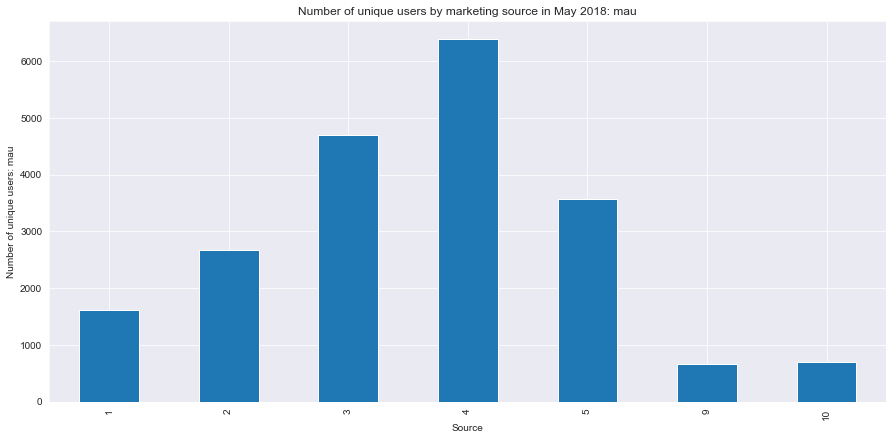

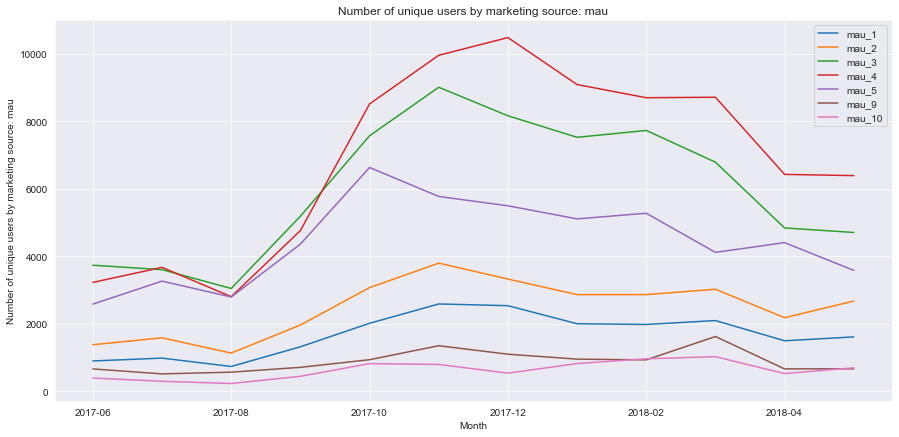

In [38]:
au_sources = au

for source in sources:
    dau = (
        (
        visits[visits['source_id'] == source]
        .groupby(['visit_month', 'date'])
        .agg({'uid': 'nunique'})
        )
        .groupby(['visit_month'])
        .agg({'uid': 'mean'})
        .rename(columns={"uid": "dau"})
    )
    dau['dau'] = dau['dau'].astype('int')

    wau = (
        (
        visits[visits['source_id'] == source]
        .groupby(['visit_month', 'week'])
        .agg({'uid': 'nunique'})
        )
        .groupby(['visit_month'])
        .agg({'uid': 'mean'})
        .rename(columns={"uid": "wau"})
    )
    wau['wau'] = wau['wau'].astype('int')

    mau = (
        visits[visits['source_id'] == source]
        .groupby('visit_month')
        .agg({'uid': 'nunique'})
        .rename(columns={"uid": "mau"})
        )

    au_source = pd.merge(pd.merge(dau, wau, how='left', on='visit_month'), mau, how='left', on='visit_month')
    au_source = au_source.add_suffix('_')
    au_source = au_source.add_suffix(source)
    au_sources = pd.merge(au_sources, au_source, how='left', on='visit_month')

for metric in ("dau", "wau", "mau"):
    df = au_sources.loc[:, au_sources.columns.str.startswith(metric+'_')]
    print('Number of unique users by marketing source: {}'.format(metric))
    display(df)

    ax = df.loc['2018-05'].plot(kind='bar', figsize=(15, 7))
    plt.title('Number of unique users by marketing source in May 2018: {}'.format(metric))
    plt.xlabel('Source')
    ax.set_xticklabels((sources))
    plt.ylabel('Number of unique users: {}'.format(metric))
    plt.show()
    
    df.plot(kind='line', figsize=(15, 7))
    plt.title('Number of unique users by marketing source: {}'.format(metric))
    plt.xlabel('Month')
    plt.ylabel('Number of unique users by marketing source: {}'.format(metric))
    plt.show()

As of the end of the analyzed period (May 2018), the largest number of unique users was attracted to the website from marketing source 4, followed by sources 3, 5, and 2 in descending order.

The dynamics of the number of unique users is similar for all marketing sources throughout the period, almost all sources maintain their positions in the number of unique users, with a few exceptions: for example, at the beginning of the period (June 2017), the leader in the number of unique users was the 3rd source, but the 4th followed him by a small margin.

Let's also evaluate the regularity of using the service - how often users access it. To do this, let's calculate the **sticky factor**.

In [39]:
dau_total = int(
    (
    visits
    .groupby(['visit_month', 'date'])
    .agg({'uid': 'nunique'})
    )
    .mean()
)

wau_total = int(
    (
    visits
    .groupby(['visit_month', 'week'])
    .agg({'uid': 'nunique'})
    )
    .mean()
)

mau_total = int(
    (
    visits
    .groupby('visit_month')
    .agg({'uid': 'nunique'})
    )
    .mean()
)

print(
    'Sticky factor (weekly/monthly): {:.0%}/{:.0%}:'
      .format(dau_total/wau_total, dau_total/mau_total)
     )

for device in (devices):
    dau_total = int(
        (
        visits[visits['device'] == device]
        .groupby(['visit_month', 'date'])
        .agg({'uid': 'nunique'})
        )
        .mean()
    )

    wau_total = int(
        (
        visits[visits['device'] == device]
        .groupby(['visit_month', 'week'])
        .agg({'uid': 'nunique'})
        )
        .mean()
    )

    mau_total = int(
        (
        visits[visits['device'] == device]
        .groupby('visit_month')
        .agg({'uid': 'nunique'})
        )
        .mean()
    )
    
    print(
    'Sticky factor (weekly/monthly) by device type {}: {:.0%}/{:.0%}:'
      .format(device, dau_total/wau_total, dau_total/mau_total)
     )

for source in (sources):
    dau_total = int(
        (
        visits[visits['source_id'] == source]
        .groupby(['visit_month', 'date'])
        .agg({'uid': 'nunique'})
        )
        .mean()
    )

    wau_total = int(
        (
        visits[visits['source_id'] == source]
        .groupby(['visit_month', 'week'])
        .agg({'uid': 'nunique'})
        )
        .mean()
    )

    mau_total = int(
        (
        visits[visits['source_id'] == source]
        .groupby('visit_month')
        .agg({'uid': 'nunique'})
        )
        .mean()
    )
    
    print(
    'Sticky factor (weekly/monthly) by marketing source {}: {:.0%}/{:.0%}:'
      .format(source, dau_total/wau_total, dau_total/mau_total)
     )

Sticky factor (weekly/monthly): 18%/4%:
Sticky factor (weekly/monthly) by device type touch: 18%/4%:
Sticky factor (weekly/monthly) by device type desktop: 18%/4%:
Sticky factor (weekly/monthly) by marketing source 1: 20%/4%:
Sticky factor (weekly/monthly) by marketing source 2: 19%/4%:
Sticky factor (weekly/monthly) by marketing source 3: 17%/3%:
Sticky factor (weekly/monthly) by marketing source 4: 18%/4%:
Sticky factor (weekly/monthly) by marketing source 5: 18%/3%:
Sticky factor (weekly/monthly) by marketing source 9: 18%/4%:
Sticky factor (weekly/monthly) by marketing source 10: 17%/4%:


The sticky factor values are low, people rarely return to the service. Values do not differ across device types and vary only slightly across marketing source types.

Let's calculate the number of sessions per day per user.

In [40]:
visits_per_user = (
    visits
    .groupby('date')
    .agg({'uid': ['count','nunique']})
)
visits_per_user.columns = ['n_sessions', 'n_users']
visits_per_user['visits_per_user'] = visits_per_user['n_sessions'] / visits_per_user['n_users']

print(
    'Average number of sessions per user per day: {:.2f}'
    .format(visits_per_user['visits_per_user'].mean())
)

for device in (devices):
    visits_per_user = (
        visits[visits['device'] == device]
        .groupby('date')
        .agg({'uid': ['count','nunique']})
    )
    visits_per_user.columns = ['n_sessions', 'n_users']
    visits_per_user['visits_per_user'] = visits_per_user['n_sessions'] / visits_per_user['n_users']
    
    print(
        'Average number of sessions per user per day, device type {}: {:.2f}'
        .format(device, 
                visits_per_user['visits_per_user'].mean())
    )

for source in (sources):
    visits_per_user = (
        visits[visits['source_id'] == source]
        .groupby('date')
        .agg({'uid': ['count','nunique']})
    )
    
    visits_per_user.columns = ['n_sessions', 'n_users']
    visits_per_user['visits_per_user'] = visits_per_user['n_sessions'] / visits_per_user['n_users']
    
    print(
        'Average number of sessions per user per day, marketing source {}: {:.2f}'
        .format(source, 
                visits_per_user['visits_per_user'].mean())
    )

Average number of sessions per user per day: 1.07
Average number of sessions per user per day, device type touch: 1.05
Average number of sessions per user per day, device type desktop: 1.08
Average number of sessions per user per day, marketing source 1: 1.13
Average number of sessions per user per day, marketing source 2: 1.07
Average number of sessions per user per day, marketing source 3: 1.01
Average number of sessions per user per day, marketing source 4: 1.02
Average number of sessions per user per day, marketing source 5: 1.04
Average number of sessions per user per day, marketing source 9: 1.01
Average number of sessions per user per day, marketing source 10: 1.04


On average, a user spends 1 session per day on the site. The value of the indicator does not vary between marketing sources and device types.

Let's analyze the duration of the session, or **ASL** (*average session length*).

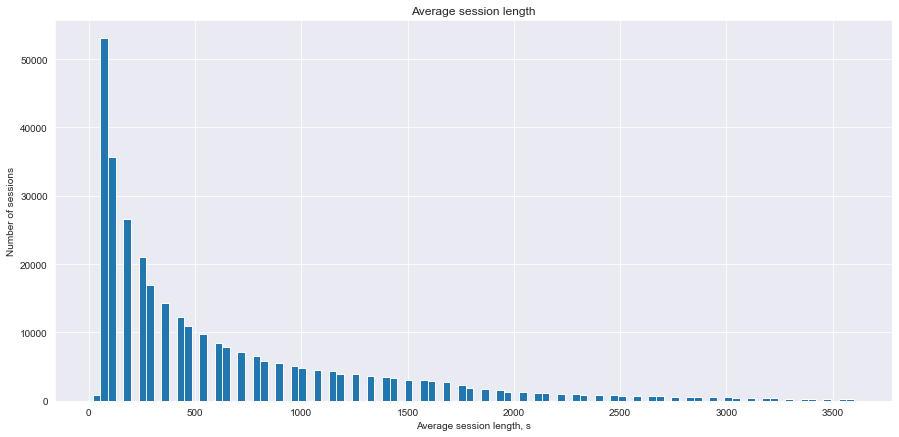

In [41]:
visits['duration'].hist(bins=100, figsize=(15,7))
plt.title('Average session length')
plt.xlabel('Average session length, s')
plt.ylabel('Number of sessions')
plt.show()

Given the type of distribution of session duration values, it is reasonable to use the mode as a measure of the average.

In [42]:
print(
    'ASL: {} s.'
    .format(visits['duration'].mode()[0]))

for device in (devices):
    print(
        'ASL by device type {}: {} s.'
        .format(device, visits[visits['device'] == device]['duration'].mode()[0]))

for source in (sources):
    print(
        'ASL by marketing source {}: {} s.'
        .format(source, visits[visits['source_id'] == source]['duration'].mode()[0]))    

ASL: 60 s.
ASL by device type touch: 60 s.
ASL by device type desktop: 60 s.
ASL by marketing source 1: 60 s.
ASL by marketing source 2: 60 s.
ASL by marketing source 3: 60 s.
ASL by marketing source 4: 60 s.
ASL by marketing source 5: 60 s.
ASL by marketing source 9: 60 s.
ASL by marketing source 10: 60 s.


The average session duration (mode) on the website does not depend on the marketing source or device type and equals to 1 minute.

Let's analyze the **Retention Rate**. To analyze whether there is a difference in the behavior of users attracted from different sources, we will take into account the source from which the user came to the website for the first time. To do this, let's create a special field in the `visits` dataframe.

In [43]:
first_visit_date = (
    visits
    .groupby('uid')['start_ts']
    .min()
)

first_visit_date.name = 'first_visit_date'

visits = visits.join(first_visit_date,on='uid')

first_visit_source = visits[visits['start_ts'] == visits['first_visit_date']]
first_visit_source = first_visit_source[['uid','source_id']]
first_visit_source = first_visit_source.rename(columns={"source_id": "first_source_id"})

visits = pd.merge(visits, first_visit_source,on='uid', how='left')

display(visits.head())

device              end_ts  source_id            start_ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
3  desktop 2017-09-03 21:36:00          5 2017-09-03 21:35:00   
4  desktop 2018-01-30 12:09:00          1 2018-01-30 11:13:00   

                    uid  duration  visit_id visit_month  week        date  \
0  16879256277535980062      1080         0     2017-12    51  2017-12-20   
1    104060357244891740      1680         1     2018-02     8  2018-02-19   
2  16174680259334210214      1440         2     2018-05    20  2018-05-20   
3  16007536194108375387        60         3     2017-09    35  2017-09-03   
4   6661610529277171451      3360         4     2018-01     5  2018-01-30   

     first_visit_date  first_source_id  
0 2017-12-20 17:20:00                4  
1 2018-02-19 16:53:00                2  
2 2018-03-09 20:05:00                4  
3 2017-09-03 21:35:00                5  
4 2017-06-29 09:00:00                2

To perform a cohort analysis, let's divide users into cohorts depending on the month of the first visit to the website and calculate the lifetime for each cohort.

In [44]:
visits['first_visit_month'] = visits['first_visit_date'].astype('datetime64[M]')
visits['visit_month'] = visits['start_ts'].astype('datetime64[M]')

visits['cohort_lifetime'] = visits['visit_month'] - visits['first_visit_month']
visits['cohort_lifetime'] = (visits['cohort_lifetime'] / np.timedelta64(1,'M')).round().astype('int')
display(visits.head())

device              end_ts  source_id            start_ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
3  desktop 2017-09-03 21:36:00          5 2017-09-03 21:35:00   
4  desktop 2018-01-30 12:09:00          1 2018-01-30 11:13:00   

                    uid  duration  visit_id visit_month  week        date  \
0  16879256277535980062      1080         0  2017-12-01    51  2017-12-20   
1    104060357244891740      1680         1  2018-02-01     8  2018-02-19   
2  16174680259334210214      1440         2  2018-05-01    20  2018-05-20   
3  16007536194108375387        60         3  2017-09-01    35  2017-09-03   
4   6661610529277171451      3360         4  2018-01-01     5  2018-01-30   

     first_visit_date  first_source_id first_visit_month  cohort_lifetime  
0 2017-12-20 17:20:00                4        2017-12-01                0  
1 2018-02-19 16:53:00                2        2018-02-01                0  
2 2018-03-09 20:05:00                4        2018-03-01                2  
3 2017-09-03 21:35:00                5        2017-09-01                0  
4 2017-06-29 09:00:00                2        2017-06-01                7

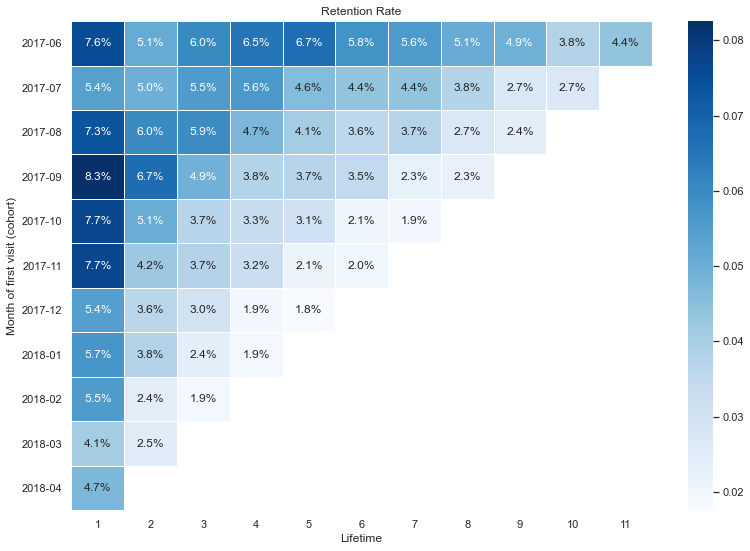

Retention Rate of an average cohort


cohort_lifetime    1     2     3     4     5     6     7     8     9     10  \
retention_rate   0.06  0.04  0.04  0.04  0.04  0.04  0.04  0.03  0.03  0.03   

cohort_lifetime    11  
retention_rate   0.04

In [45]:
cohorts = (
    visits
    .groupby(['first_visit_month','cohort_lifetime'])
    .agg({'uid':'nunique'})
    .reset_index()
)

initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

cohorts = cohorts.merge(initial_users_count, on='first_visit_month')
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
cohorts['first_visit_month'] = cohorts['first_visit_month'].dt.strftime('%Y-%m')

retention_pivot = cohorts.pivot_table(index='first_visit_month',
                                      columns='cohort_lifetime',
                                      values='retention',
                                      aggfunc='sum').drop(0, axis=1).drop('2018-05', axis=0)
sns.set(style='white')
plt.figure(figsize=(13, 9))
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='white', cmap="Blues")
plt.title('Retention Rate')
plt.xlabel('Lifetime')
plt.ylabel('Month of first visit (cohort)')
plt.yticks(rotation=0)
plt.show()
print('Retention Rate of an average cohort')
display(retention_pivot.mean(axis=0).reset_index().set_index('cohort_lifetime').rename(columns={0:'retention_rate'}).T)

After a month, less than 10% of users in each cohort continue to visit the website; for a number of cohorts this figure is less than 5%. The service has a low Retention Rate: after users get to the site for the first time, they do not become loyal users. 

Let's analyze whether the Retention Rate depends on the device type.

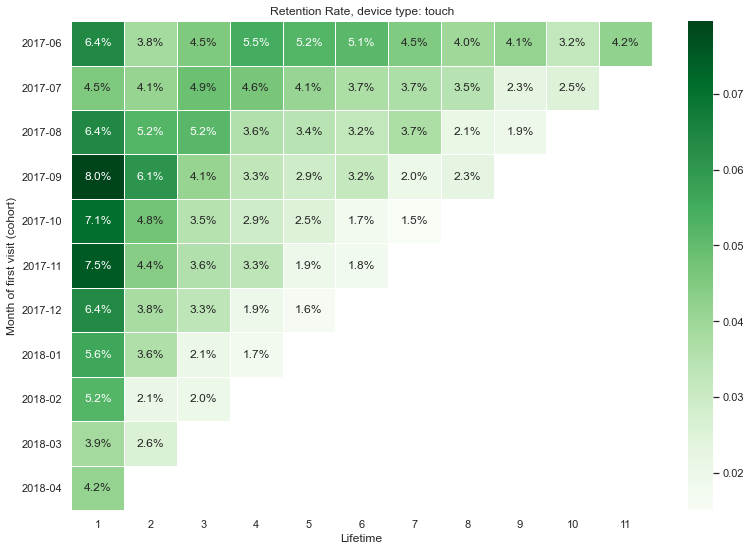

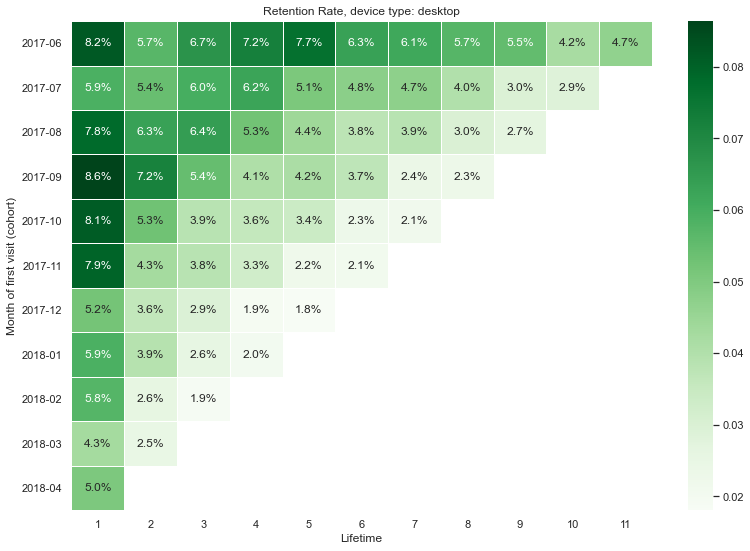

In [46]:
for device in devices:
    cohorts = (
    visits[visits['device'] == device]
    .groupby(['first_visit_month','cohort_lifetime'])
    .agg({'uid':'nunique'})
    .reset_index()
    )

    initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month','uid']]
    initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

    cohorts = cohorts.merge(initial_users_count, on='first_visit_month')
    cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
    cohorts['first_visit_month'] = cohorts['first_visit_month'].dt.strftime('%Y-%m')

    retention_pivot = cohorts.pivot_table(index='first_visit_month',
                                      columns='cohort_lifetime',
                                      values='retention',
                                      aggfunc='sum').drop(0, axis=1).drop('2018-05', axis=0)
    
    sns.set(style='white')
    plt.figure(figsize=(13, 9))
    sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='white', cmap='Greens')
    plt.title('Retention Rate, device type: {}'.format(device))
    plt.xlabel('Lifetime')
    plt.ylabel('Month of first visit (cohort)')
    plt.yticks(rotation=0)
    plt.show()

Retention Rate does not differ by device type.

Let's analyze the Retention Rate by marketing source.

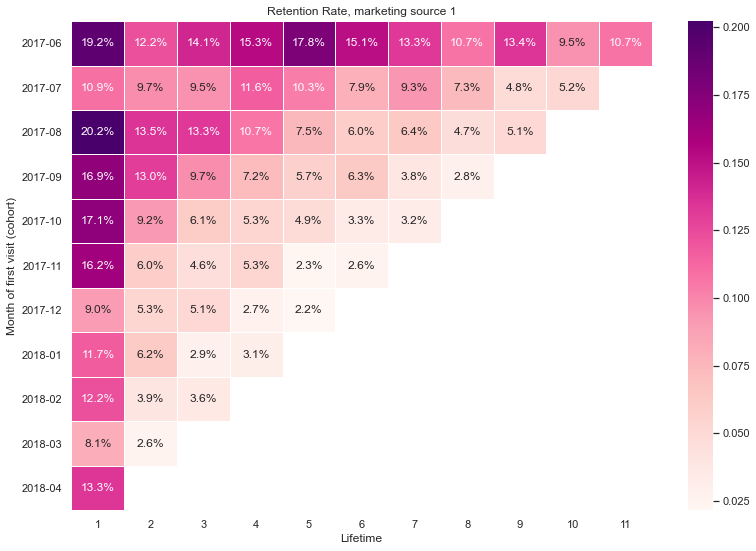

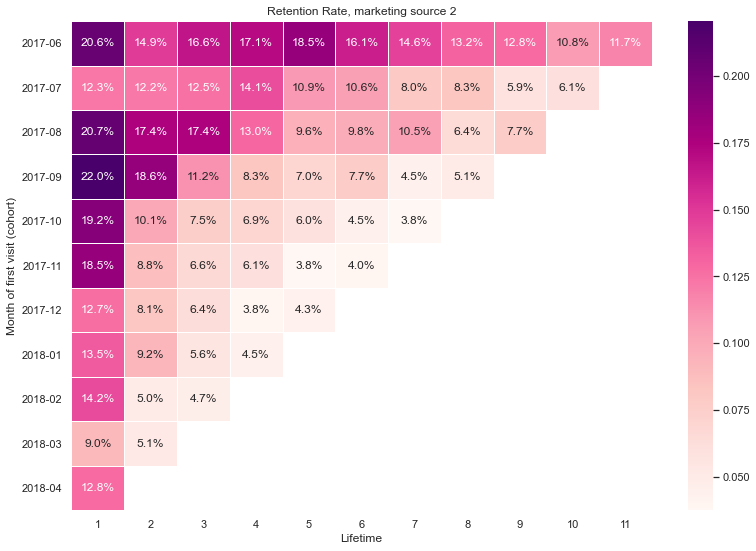

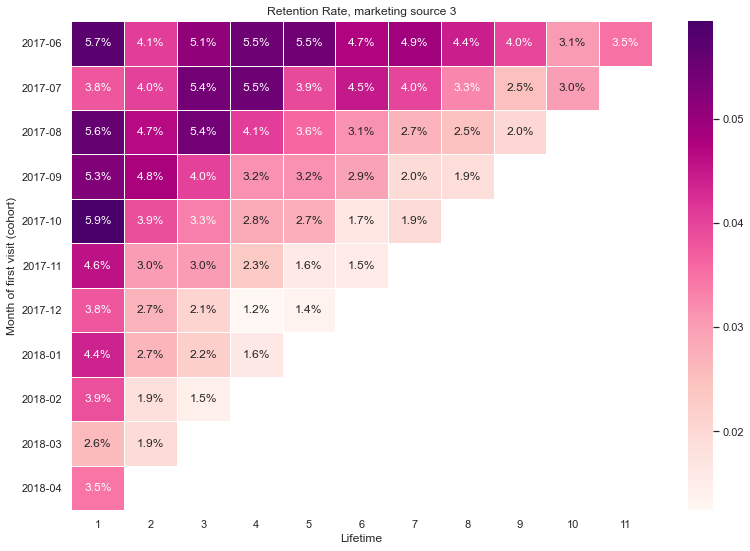

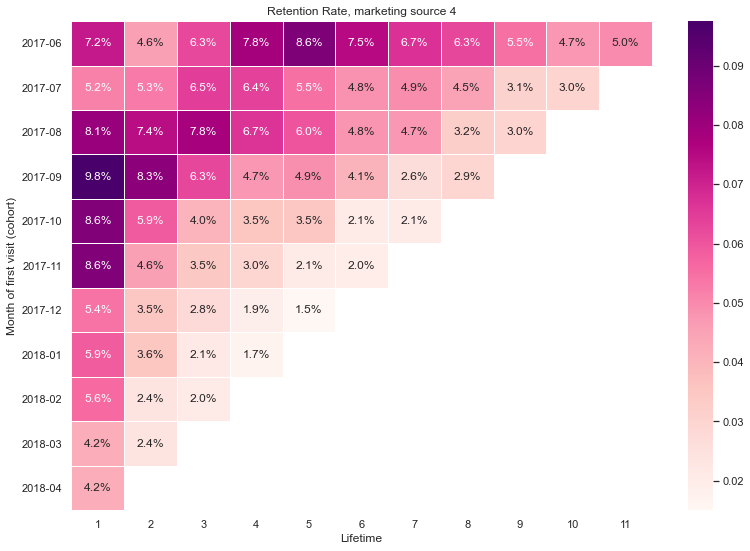

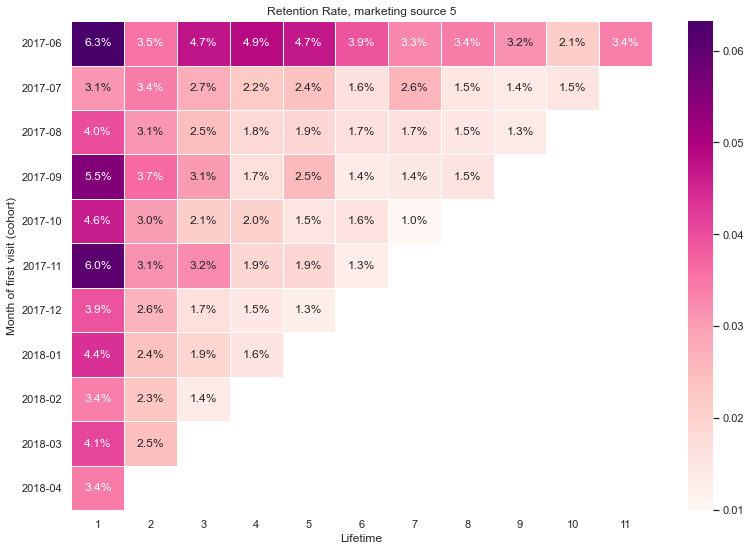

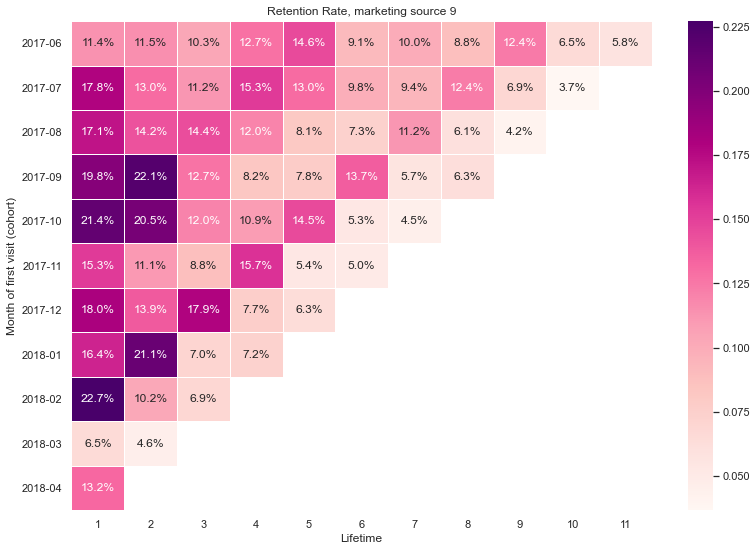

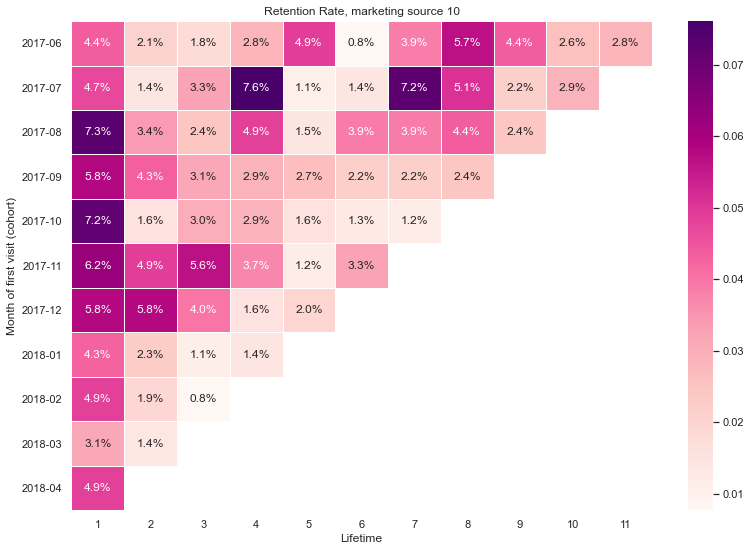

In [47]:
for source in sources:
    cohorts = (
    visits[visits['source_id'] == source]
    .groupby(['first_visit_month','cohort_lifetime'])
    .agg({'uid':'nunique'})
    .reset_index()
    )

    initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month','uid']]
    initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

    cohorts = cohorts.merge(initial_users_count, 
                            on='first_visit_month')
    cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
    cohorts['first_visit_month'] = cohorts['first_visit_month'].dt.strftime('%Y-%m')

    retention_pivot = cohorts.pivot_table(index='first_visit_month',
                                      columns='cohort_lifetime',
                                      values='retention',
                                      aggfunc='sum').drop(0, axis=1).drop('2018-05', axis=0)
    
    sns.set(style='white')
    plt.figure(figsize=(13, 9))
    sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='white', cmap='RdPu')
    plt.title('Retention Rate, marketing source {}'.format(source))
    plt.xlabel('Lifetime')
    plt.ylabel('Month of first visit (cohort)')
    plt.yticks(rotation=0)
    plt.show()

Sources 2, 1, and 9 show a higher Retention Rate: in the first month, for a number of cohorts, the value of the indicator exceeds 20%. At the same time, there is no increase in the Retention Rate from earlier to later cohorts.

### Conclusion for the **Product** section
* At the end of the analyzed period, the website was used by an average of 696 people per day, 4,003 people per week, and 18,429 people per month. The use of the site is characterized by pronounced seasonality: the number of unique users more than doubles before the New Year and spring holidays compared to the summer period.
* On average, a user spends 1 session per day on the website. The duration of one session is 60 seconds. The number of unique users from desktop devices is more than twice the number of unique users from touch devices.
* Users rarely return to the website - the sticky factor per week/month is only 18%/4%. The site has a low Retention Rate, only 6% of users return to it in the second month.
* As of the end of the analyzed period, the largest number of unique users were attracted to the website from marketing sources 4, 3, 5, and 2. The dynamics of the number of unique users by attraction sources is similar. A number of marketing sources have a higher Retention Rate: these include 2, 1 and 9.

## Sales <a id="2.2"></a>   
</div>

Let's analyze the data on the orders made by users on the website.

To understand when people start buying, how many times they buy during a period, what is the average check and LTV, and to analyze other indicators by month, we need to perform a cohort analysis. To divide users into cohorts, we will use the month of the first visit to the website. To analyze whether there is a difference in the behavior of users attracted from different sources, we will take into account the source from which the user came to the website for the first time.

Let's add the necessary columns to the `orders` dataframe.

In [48]:
orders = orders.join(first_visit_date,on='uid')

orders = pd.merge(orders, 
                  first_visit_source,
                  on='uid', 
                  how='left')

display(orders.head())

buy_ts  revenue                   uid  order_id  \
0 2017-06-01 00:10:00    17.00  10329302124590727494         0   
1 2017-06-01 00:25:00     0.55  11627257723692907447         1   
2 2017-06-01 00:27:00     0.37  17903680561304213844         2   
3 2017-06-01 00:29:00     0.55  16109239769442553005         3   
4 2017-06-01 07:58:00     0.37  14200605875248379450         4   

     first_visit_date  first_source_id  
0 2017-06-01 00:09:00             1.00  
1 2017-06-01 00:14:00             2.00  
2 2017-06-01 00:25:00             2.00  
3 2017-06-01 00:14:00             2.00  
4 2017-06-01 07:31:00             3.00

Let's check if there are any orders in the dataframe for which the order date is earlier than the date of the first visit. This is possible if the user visited the site before the start of the period, or if the user got to the site from some source that we did not include in the analysis. If there is such data, they need to be deleted (since we do not know from which sources these users came to the website, and therefore we can't use information on them in the analysis).

In [52]:
orders = orders[orders['first_visit_date'] <= orders['buy_ts']].copy()

In [53]:
print(
    'Total revenue for analyzed orders in June 2017 - May 2018: {:.2f}'
    .format(orders['revenue'].sum())
)

print(
    'Total number of orders by analyzed users in June 2017 - May 2018: {:.2f}'
    .format(orders['order_id'].count())
)

Total revenue for analyzed orders in June 2017 - May 2018: 199184.79
Total number of orders by analyzed users in June 2017 - May 2018: 48443.00


To perform a cohort analysis, let's divide users into cohorts depending on the month of the first visit and calculate the lifetime for each cohort.

In [54]:
orders['first_visit_month'] = orders['first_visit_date'].astype('datetime64[M]')
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')

orders['cohort_lifetime'] = orders['order_month'] - orders['first_visit_month']
orders['cohort_lifetime'] = (orders['cohort_lifetime'] / np.timedelta64(1,'M')).round().astype('int')

Let's analyze by cohorts during which month users start buying.

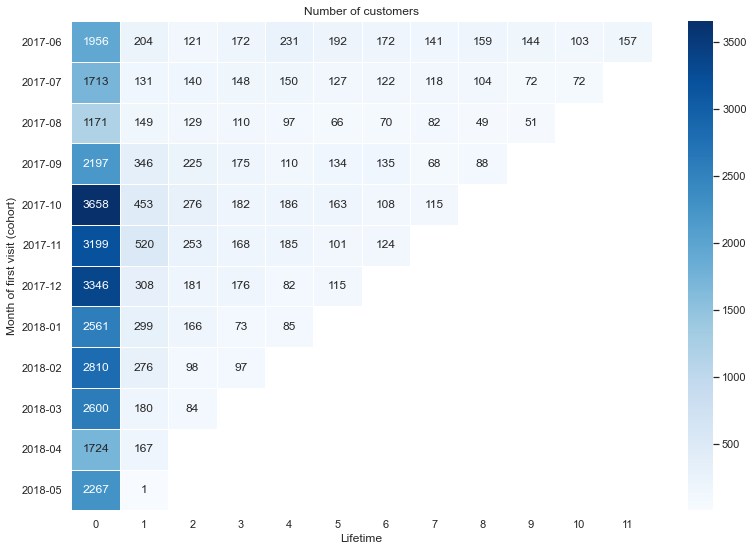

In [55]:
cohorts = (
    orders
    .groupby(['first_visit_month','cohort_lifetime'])
    .agg({'uid':'nunique'})
    .reset_index()
)

cohorts['first_visit_month'] = cohorts['first_visit_month'].dt.strftime('%Y-%m')

buyers_pivot = cohorts.pivot_table(index='first_visit_month',
                                      columns='cohort_lifetime',
                                      values='uid',
                                      aggfunc='sum')
sns.set(style='white')
plt.figure(figsize=(13, 9))
sns.heatmap(buyers_pivot, annot=True, fmt='.0f', linewidths=1, linecolor='white', cmap="Blues")
plt.title('Number of customers')
plt.xlabel('Lifetime')
plt.ylabel('Month of first visit (cohort)')
plt.yticks(rotation=0)
plt.show()

The largest number of orders in each cohort occurs in the month of the first visit to the site, after which the number of orders per month decreases significantly.

Let's analyze whether the dynamics of the number of customers differs depending on marketing source.

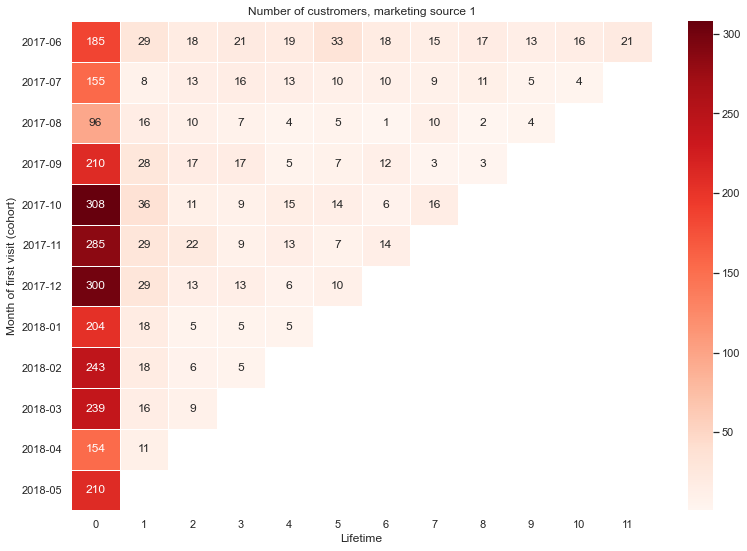

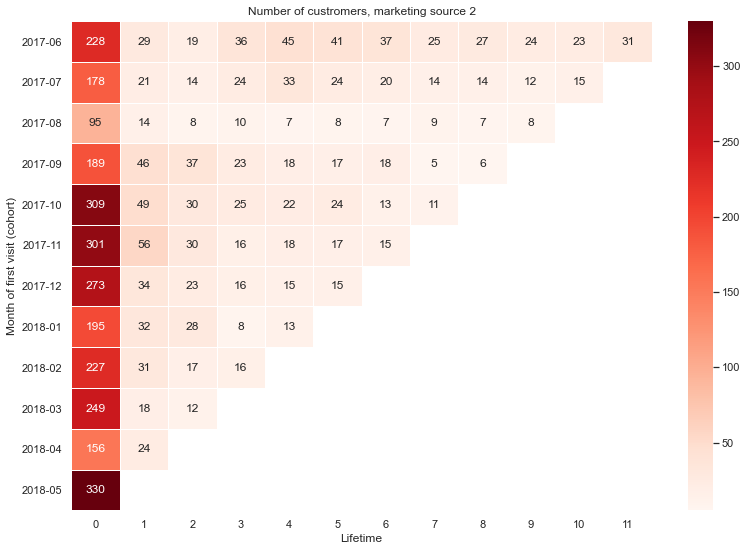

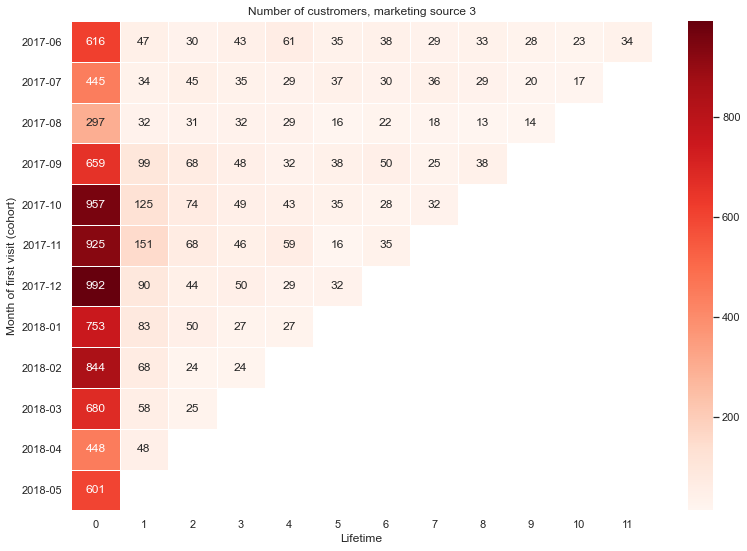

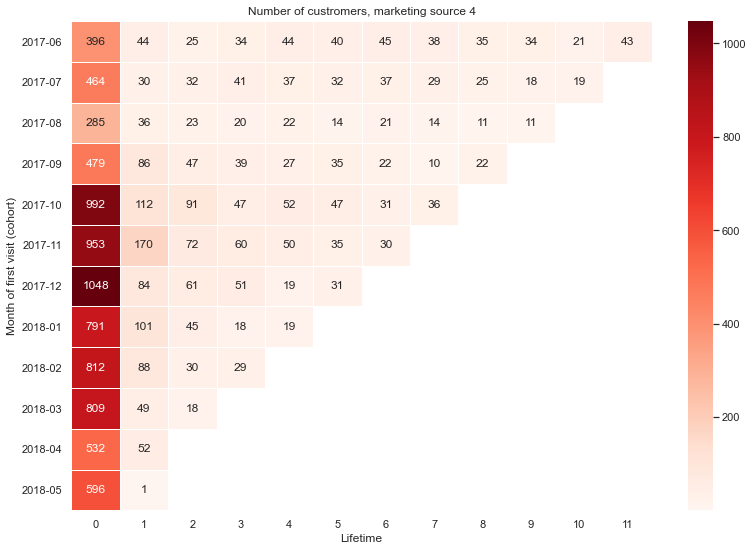

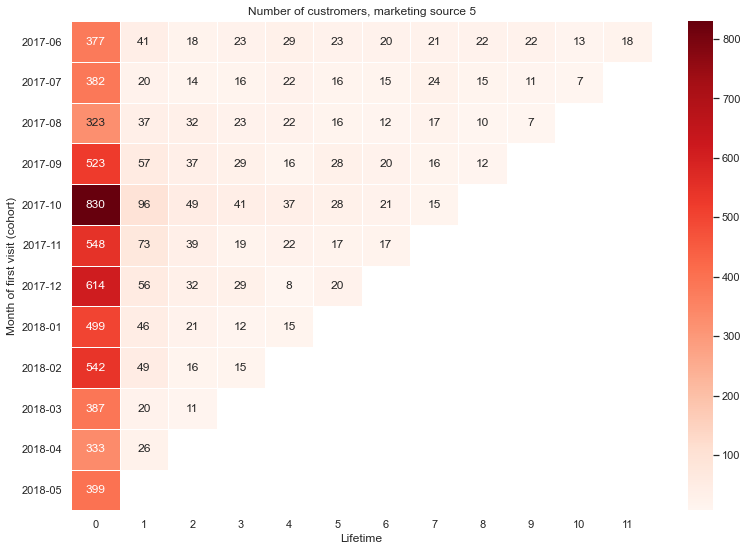

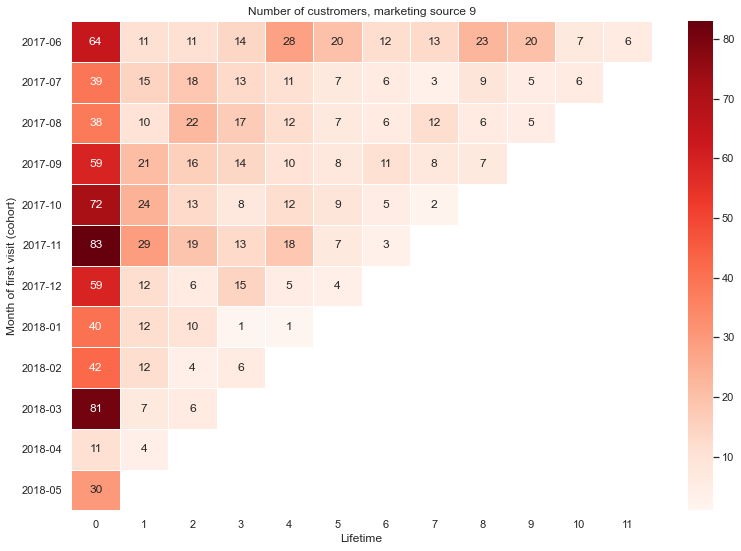

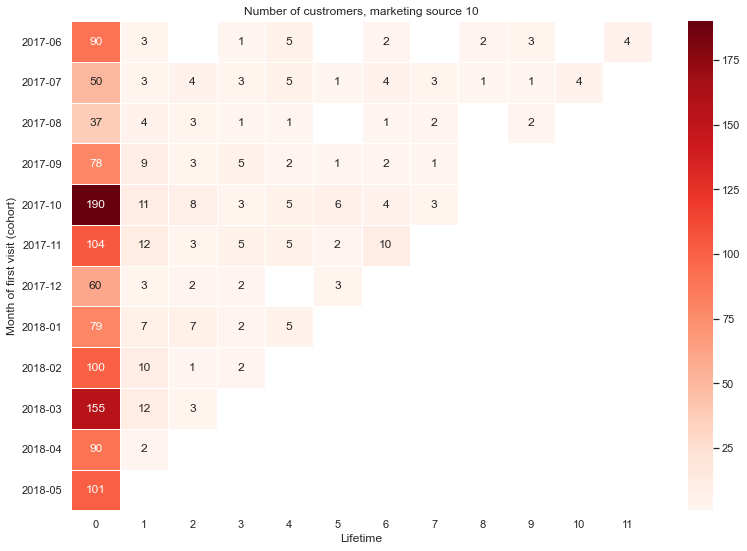

In [56]:
for source in sources:
    cohorts = (
        orders[orders['first_source_id'] == source]
        .groupby(['first_visit_month','cohort_lifetime'])
        .agg({'uid':'nunique'})
        .reset_index()
    )

    cohorts['first_visit_month'] = cohorts['first_visit_month'].dt.strftime('%Y-%m')

    buyers_pivot = cohorts.pivot_table(index='first_visit_month',
                                      columns='cohort_lifetime',
                                      values='uid',
                                      aggfunc='sum')
    sns.set(style='white')
    plt.figure(figsize=(13, 9))
    sns.heatmap(buyers_pivot, annot=True, fmt='.0f', linewidths=1, linecolor='white', cmap="Reds")
    plt.title('Number of custromers, marketing source {}'.format(source))
    plt.xlabel('Lifetime')
    plt.ylabel('Month of first visit (cohort)')
    plt.yticks(rotation=0)
    plt.show()

For all marketing sources, users make the largest number of orders in the month of their first visit to the website. Source 9 stands out, the number of customers coming from this source remains at a relatively high level in subsequent months.

Let's analyze how the average order revenue changes over time.

Average order revenue: 4.11


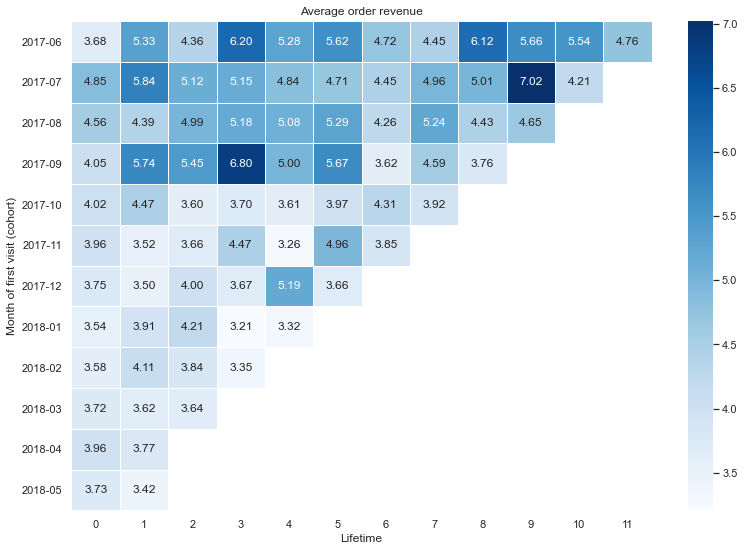

In [58]:
print('Average order revenue: {:.2f}'.format(orders['revenue'].mean()))

cohorts = (
    orders
    .groupby(['first_visit_month','cohort_lifetime'])
    .agg({'revenue':'mean'})
    .reset_index()
)

cohorts['first_visit_month'] = cohorts['first_visit_month'].dt.strftime('%Y-%m')

buyers_pivot = cohorts.pivot_table(index='first_visit_month',
                                      columns='cohort_lifetime',
                                      values='revenue',
                                      aggfunc='mean')
sns.set(style='white')
plt.figure(figsize=(13, 9))
sns.heatmap(buyers_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='white', cmap="Blues")
plt.title('Average order revenue')
plt.xlabel('Lifetime')
plt.ylabel('Month of first visit (cohort)')
plt.yticks(rotation=0)
plt.show()

The average revenue of an order is 4.11, it is difficult to reveal any patterns in the dynamics of the average order cost over time. 

Let's analyze the average revenue of an order by marketing source.

Average order revenue, marketing source 1: 4.75


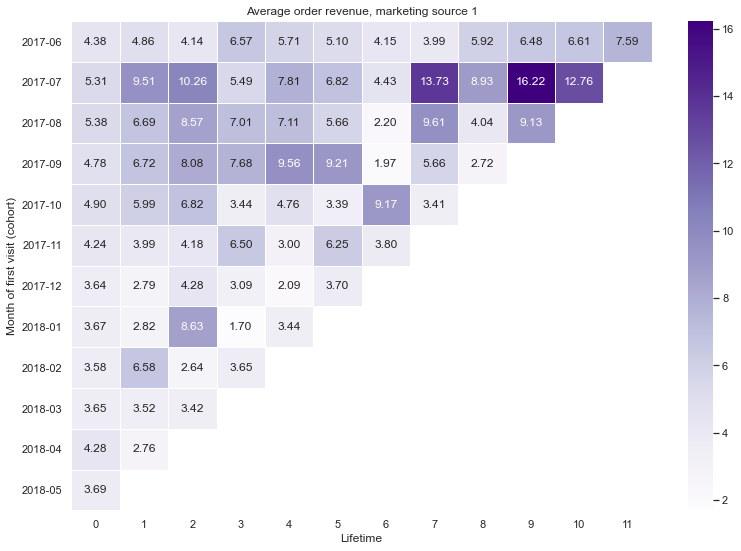

Average order revenue, marketing source 2: 4.80


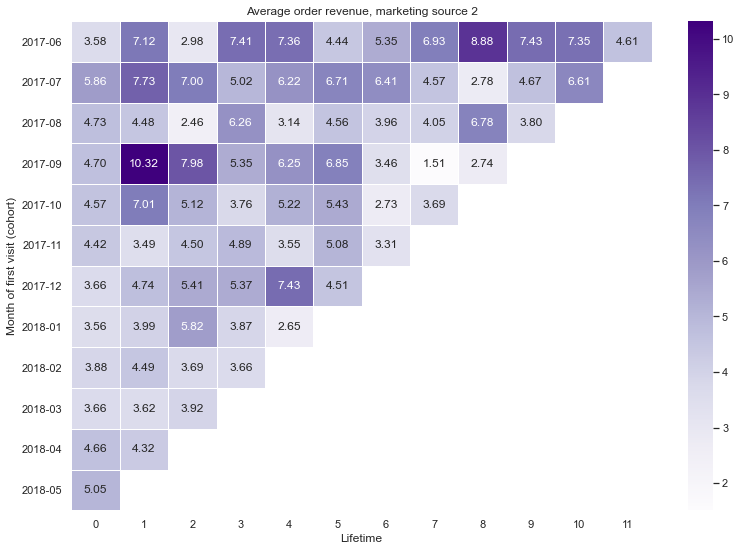

Average order revenue, marketing source 3: 3.69


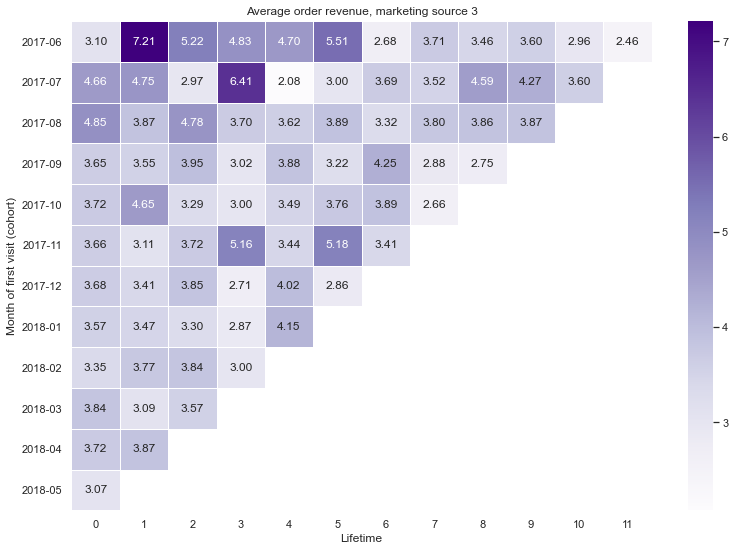

Average order revenue, marketing source 4: 4.01


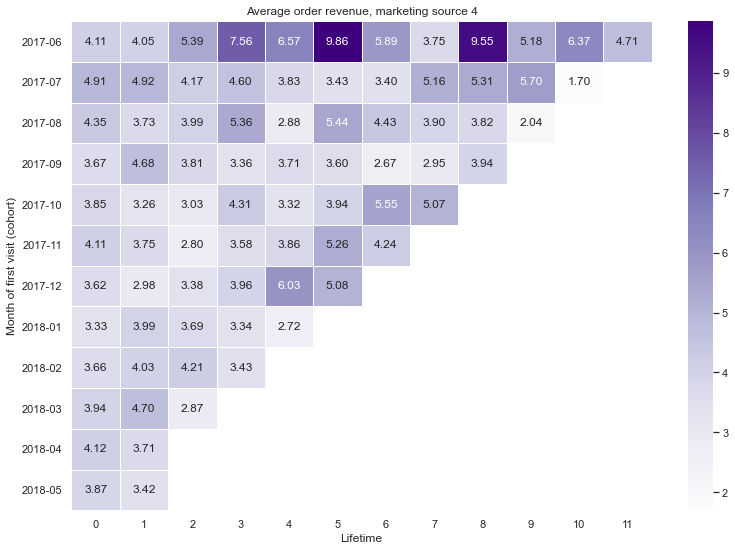

Average order revenue, marketing source 5: 4.34


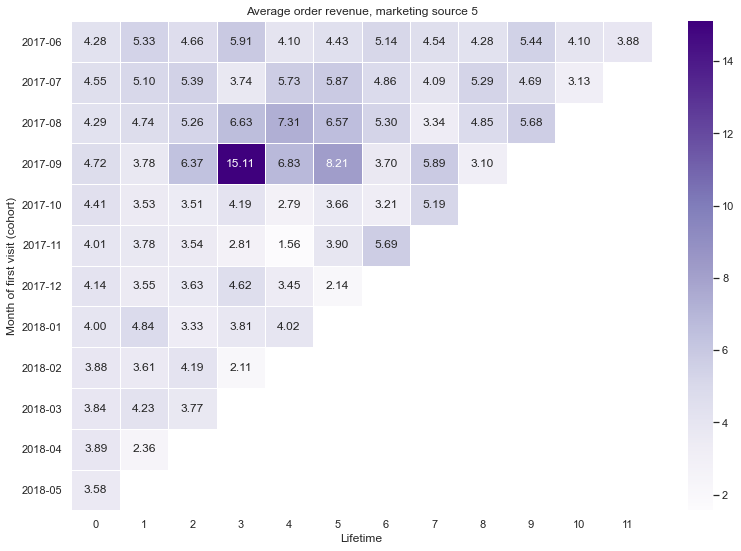

Average order revenue, marketing source 9: 3.38


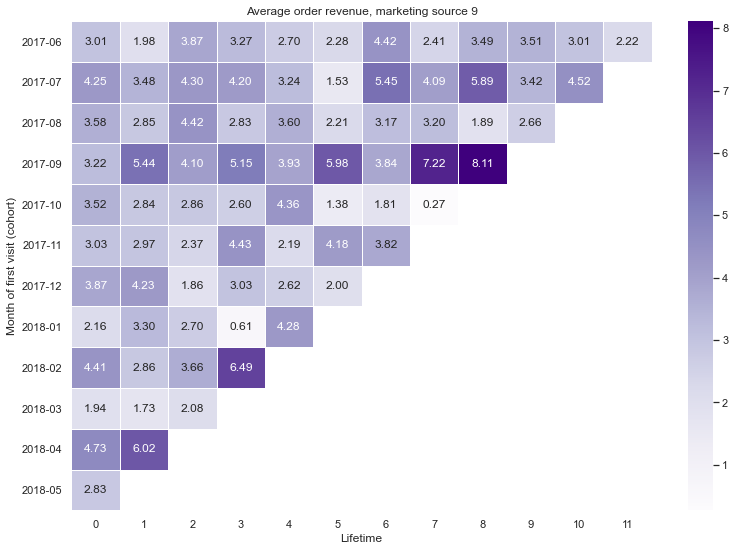

Average order revenue, marketing source 10: 2.95


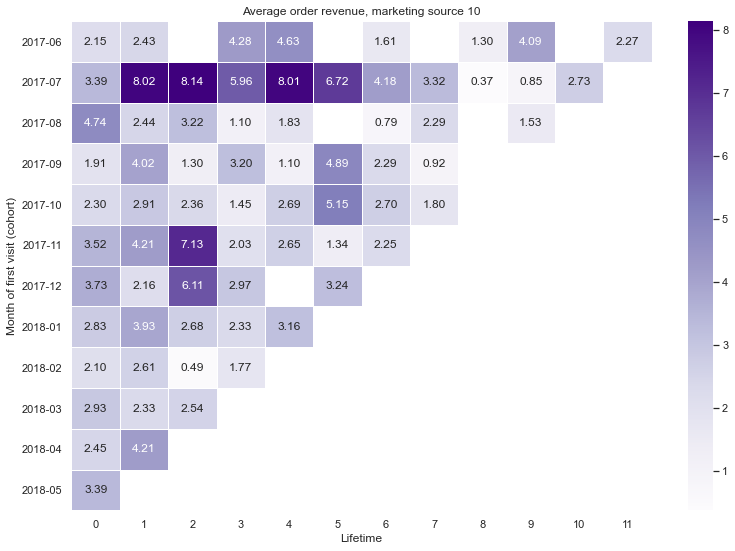

In [60]:
for source in sources:
    
    print(
        'Average order revenue, marketing source {}: {:.2f}'
        .format(source, 
                orders[orders['first_source_id'] == source]['revenue'].mean())
    )
    
    cohorts = (
        orders[orders['first_source_id'] == source]
        .groupby(['first_visit_month','cohort_lifetime'])
        .agg({'revenue':'mean'})
        .reset_index()
    )

    cohorts['first_visit_month'] = cohorts['first_visit_month'].dt.strftime('%Y-%m')

    buyers_pivot = cohorts.pivot_table(index='first_visit_month',
                                      columns='cohort_lifetime',
                                      values='revenue',
                                      aggfunc='mean')
    sns.set(style='white')
    plt.figure(figsize=(13, 9))
    sns.heatmap(buyers_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='white', cmap="Purples")
    plt.title('Average order revenue, marketing source {}'.format(source))
    plt.xlabel('Lifetime')
    plt.ylabel('Month of first visit (cohort)')
    plt.yticks(rotation=0)
    plt.show()

The average order revenue differs somewhat depending on the marketing source: it is minimal in the case of source 10 (2.95) and maximum in the case of source 2 (4.80). Patterns in the dynamics of the average order revenue have not been revealed.

Let's analyze how often users place orders.

Average number of orders per customer: 1.4


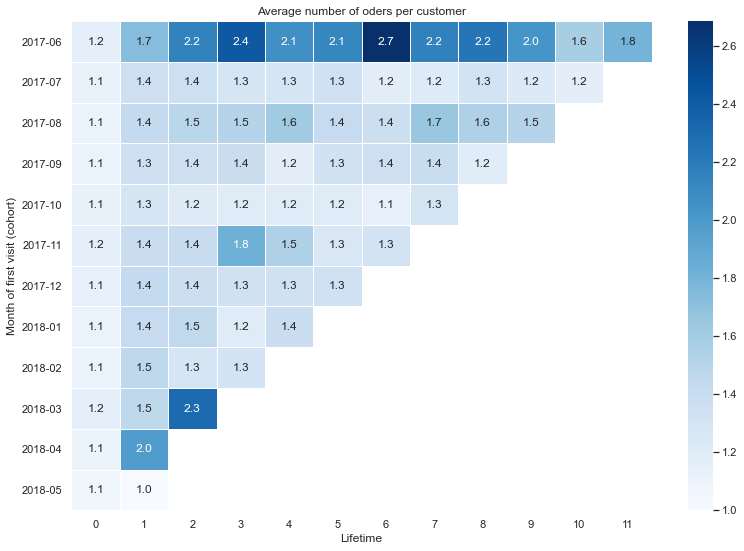

In [61]:
print(
    'Average number of orders per customer: {:.1f}'
    .format(orders['uid'].count()/orders['uid'].nunique())
)

cohorts = (
    orders
    .groupby(['first_visit_month','cohort_lifetime'])
    .agg({'uid':'nunique', 'order_id':'count'})
    .reset_index()
)

cohorts['first_visit_month'] = cohorts['first_visit_month'].dt.strftime('%Y-%m')
cohorts['orders_per_user'] = cohorts['order_id']/cohorts['uid']

orders_per_user = cohorts.pivot_table(index='first_visit_month',
                                      columns='cohort_lifetime',
                                      values='orders_per_user',
                                      aggfunc='mean')
sns.set(style='white')
plt.figure(figsize=(13, 9))
sns.heatmap(orders_per_user, annot=True, fmt='.1f', linewidths=1, linecolor='white', cmap="Blues")
plt.title('Average number of oders per customer')
plt.xlabel('Lifetime')
plt.ylabel('Month of first visit (cohort)')
plt.yticks(rotation=0)
plt.show()

The average number of orders per customer in the cohort increases in the second month compared to the first, in subsequent months it also remains at a higher level than in the first month. The average number of orders of users of the first cohort is on average higher than that of the rest.

Let's analyze the change in the average number of orders per user depending on the marketing source.

Average number of users per customer, marketing source 1: 1.7


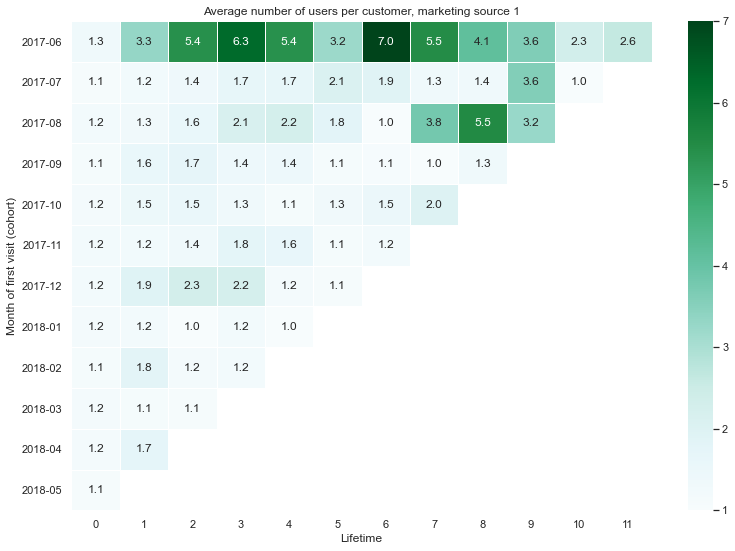

Average number of users per customer, marketing source 2: 1.8


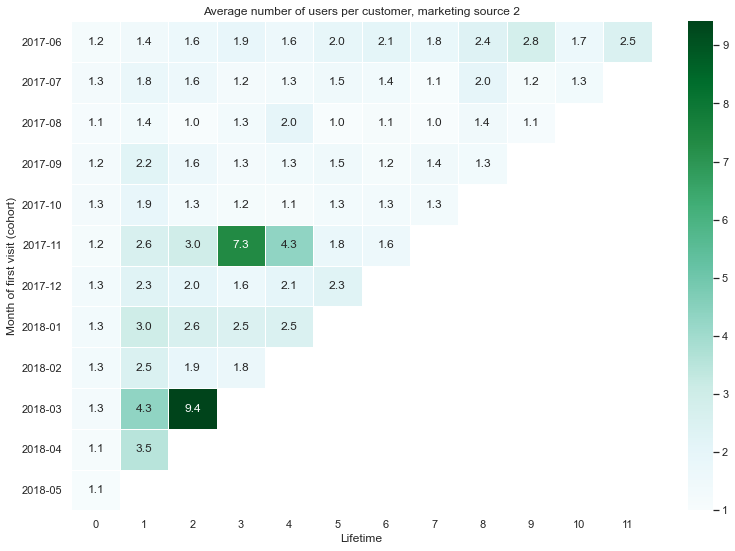

Average number of users per customer, marketing source 3: 1.3


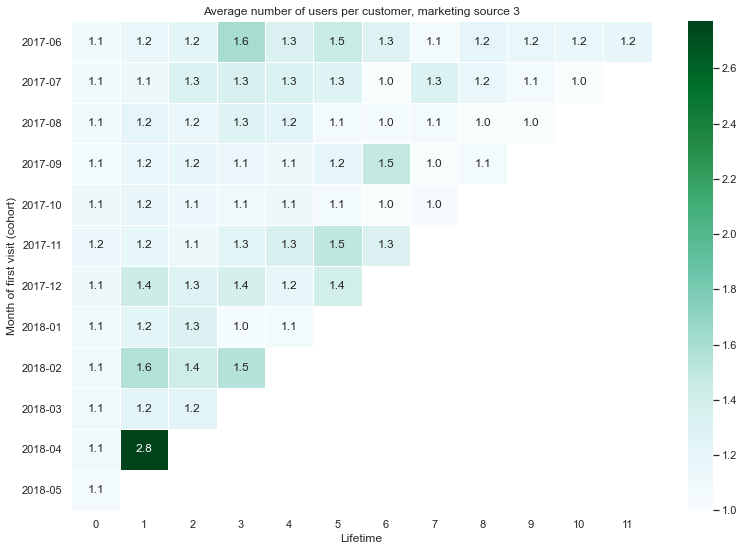

Average number of users per customer, marketing source 4: 1.2


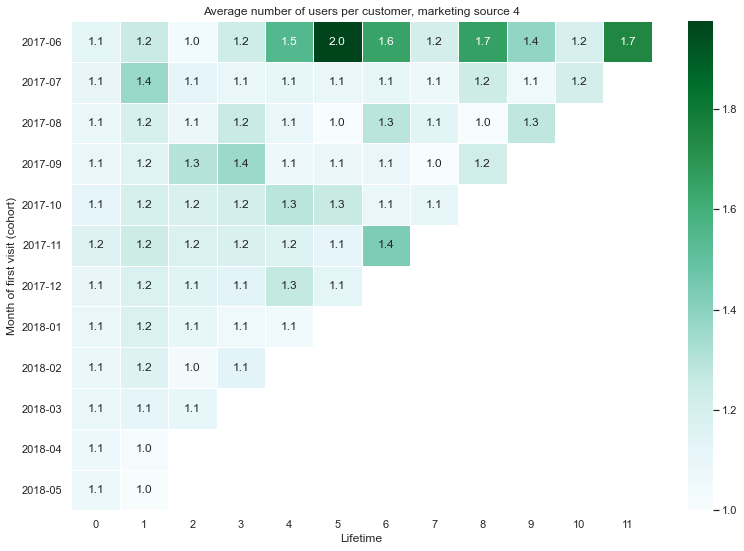

Average number of users per customer, marketing source 5: 1.4


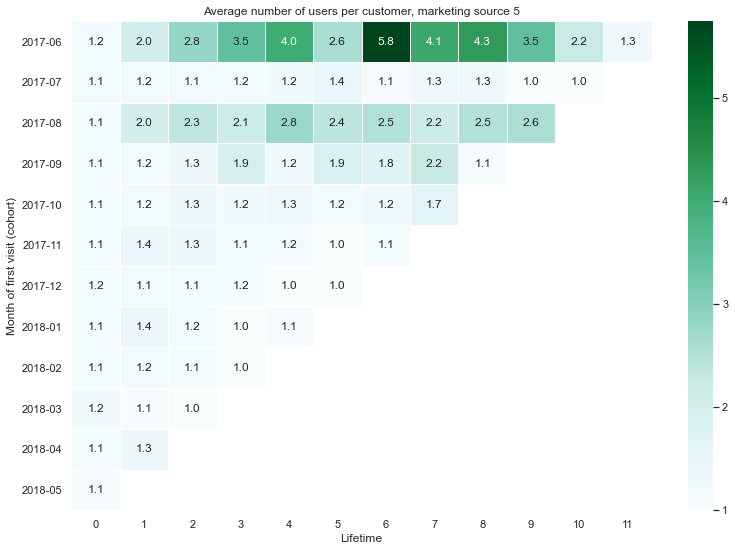

Average number of users per customer, marketing source 9: 1.5


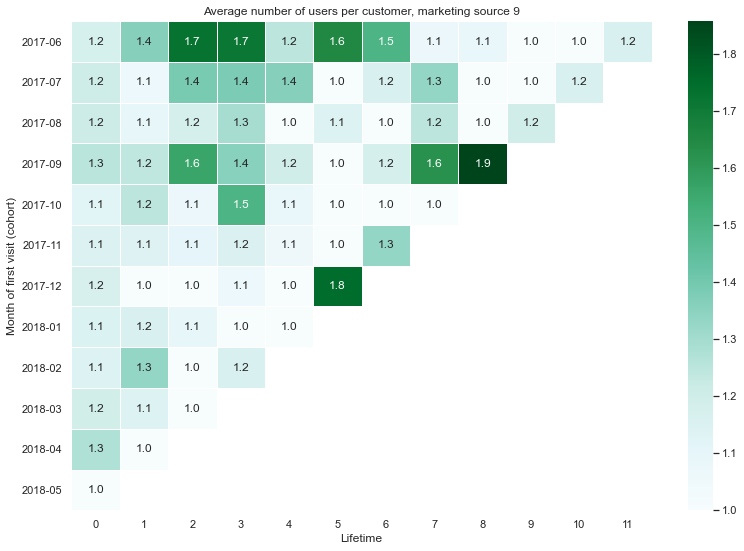

Average number of users per customer, marketing source 10: 1.2


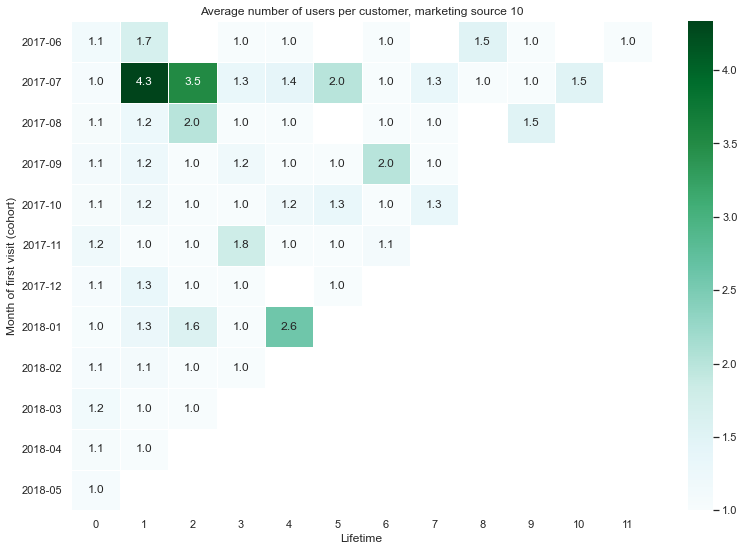

In [62]:
for source in sources:
    print(
        'Average number of users per customer, marketing source {}: {:.1f}'
        .format(source,
            orders[orders['first_source_id'] == source]['uid'].count()/
                orders[orders['first_source_id'] == source]['uid'].nunique())
    )

    cohorts = (
        orders[orders['first_source_id'] == source]
        .groupby(['first_visit_month','cohort_lifetime'])
        .agg({'uid':'nunique', 'order_id':'count'})
        .reset_index()
    )

    cohorts['first_visit_month'] = cohorts['first_visit_month'].dt.strftime('%Y-%m')
    cohorts['orders_per_user'] = cohorts['order_id']/cohorts['uid']

    orders_per_user = cohorts.pivot_table(index='first_visit_month',
                                      columns='cohort_lifetime',
                                      values='orders_per_user',
                                      aggfunc='mean')
    sns.set(style='white')
    plt.figure(figsize=(13, 9))
    sns.heatmap(orders_per_user, annot=True, fmt='.1f', linewidths=1, linecolor='white', cmap="BuGn")
    plt.title('Average number of users per customer, marketing source {}'.format(source))
    plt.xlabel('Lifetime')
    plt.ylabel('Month of first visit (cohort)')
    plt.yticks(rotation=0)
    plt.show()

The maximum average number of orders per customer is observed in the case of sources 1 and 2. In case of source 1, the highest number of orders is made in the first cohort, in the case of the fifth source, the first and third cohorts are outstanding.

Let's find **LTV** ("lifetime" value of the client) per month, that is, the total amount of money that one client brings on average from all his purchases. 

Let's divide the gross profit of the cohorts for each month by the total number of users in each cohort. The service margin is assumed to be 1.

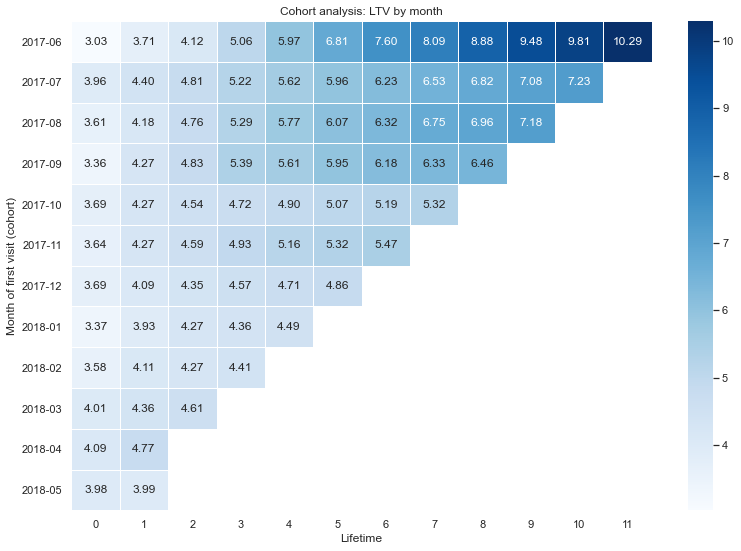

In [63]:
cohort_sizes = (
    (
        orders
        .groupby('first_visit_month')
        .agg({'uid': 'nunique'})
    )
    .reset_index()
)

cohort_sizes.columns = ['first_visit_month', 'n_buyers']

margin_rate = 1

cohorts = (
    (
        orders
        .groupby(['first_visit_month','cohort_lifetime'])
        .agg({'revenue': 'sum'})
    )
    .reset_index()
)

report = pd.merge(cohort_sizes, 
                  cohorts, 
                  on='first_visit_month')

report['gp'] =  report['revenue'] * margin_rate
report['ltv'] = report['gp'] / report['n_buyers']
report['first_visit_month'] = report['first_visit_month'].dt.strftime('%Y-%m')

result = (
    report
    .pivot_table(index='first_visit_month', 
                 columns='cohort_lifetime', 
                 values='ltv', 
                 aggfunc='mean')
)

for col in range(1, 12):
    result[col] = result[col-1]+result[col]

sns.set(style='white')
plt.figure(figsize=(13, 9))
sns.heatmap(result, annot=True, fmt='.2f', linewidths=1, linecolor='white', cmap="Blues")
plt.title('Cohort analysis: LTV by month')
plt.xlabel('Lifetime')
plt.ylabel('Month of first visit (cohort)')
plt.yticks(rotation=0)
plt.show()

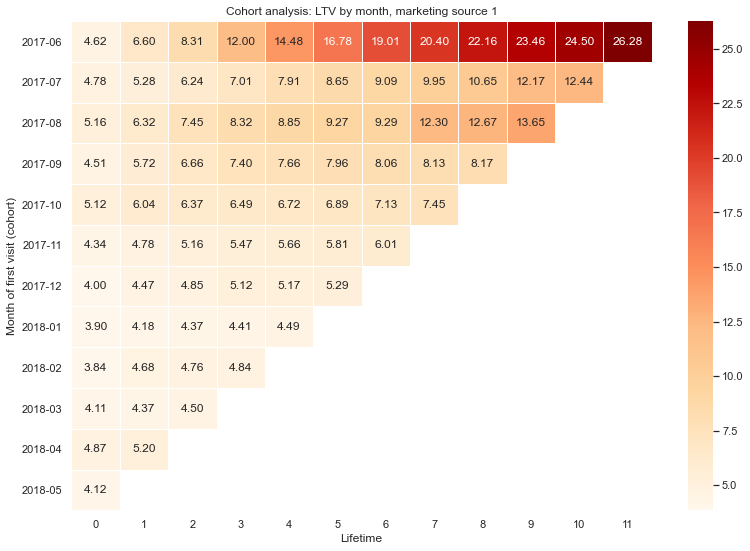

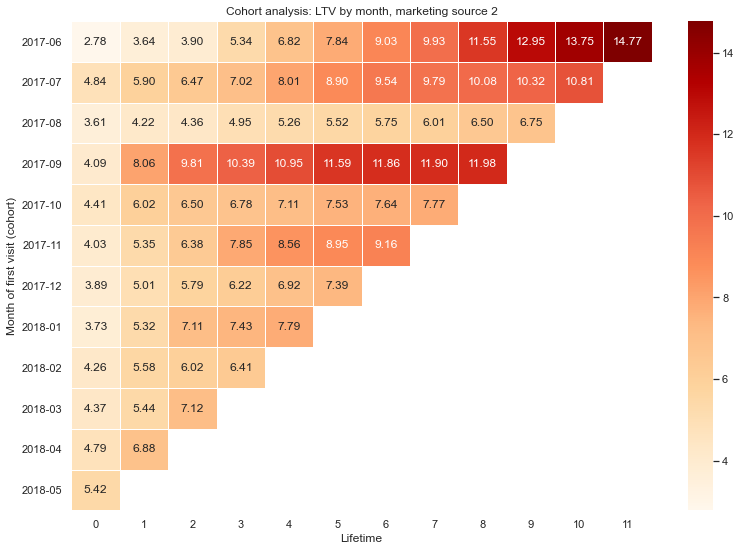

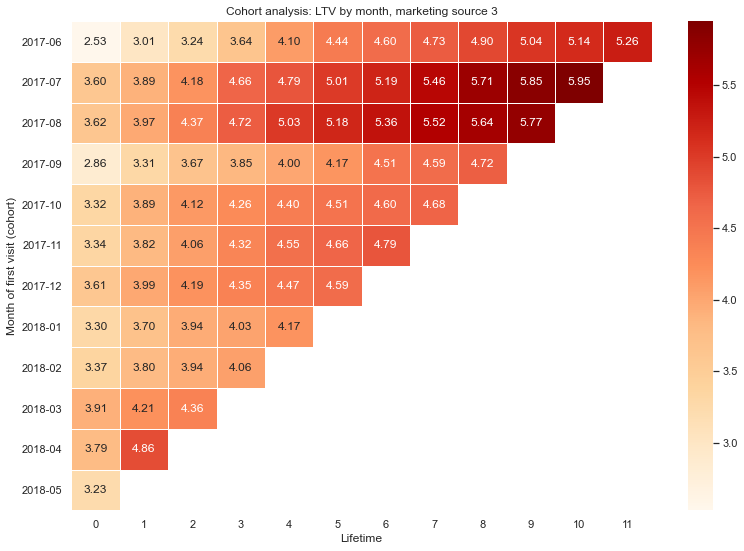

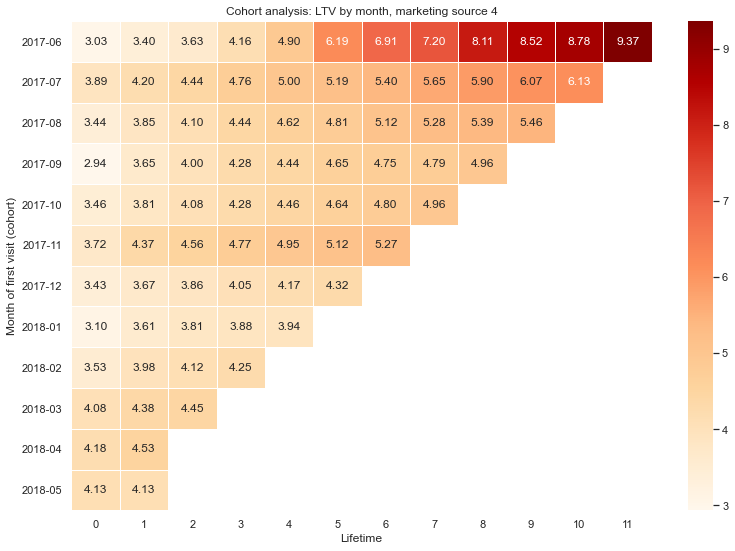

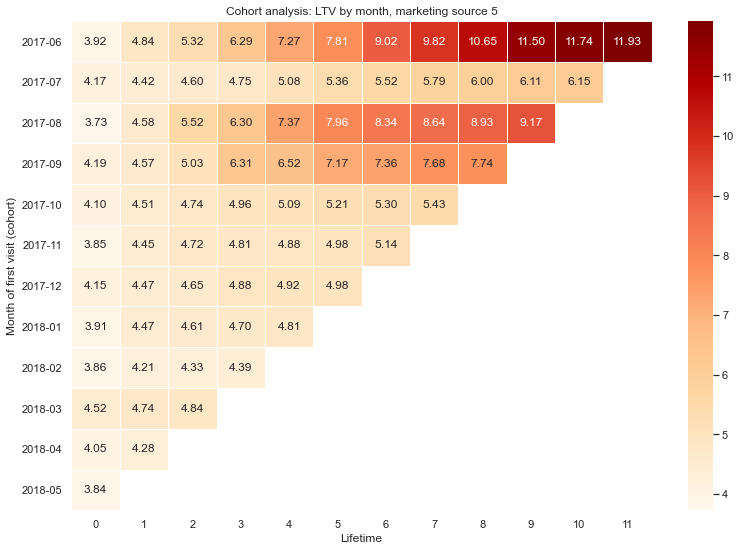

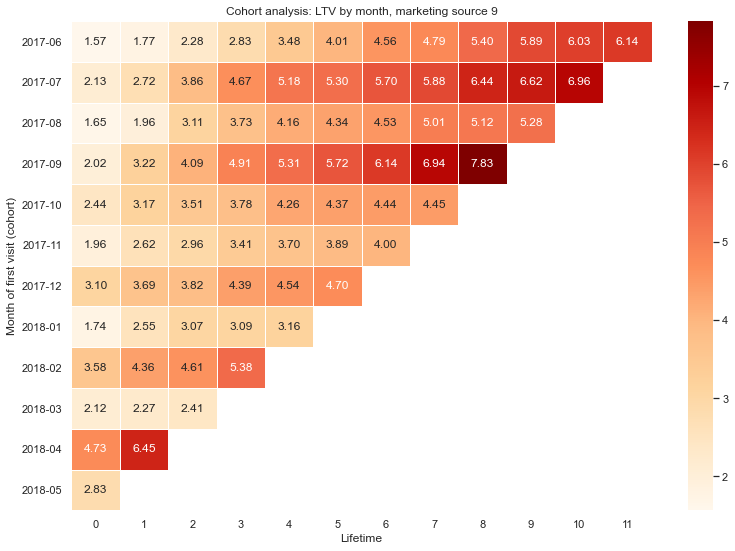

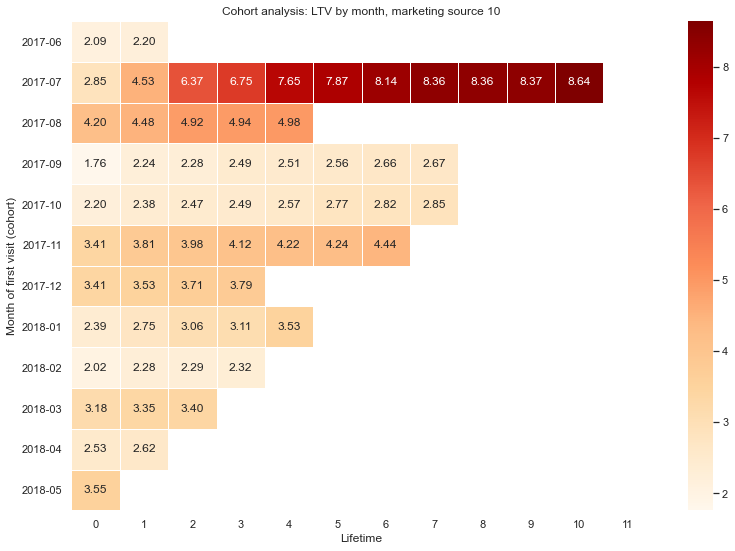

In [64]:
for source in sources:
    cohort_sizes = (
        (
            orders[orders['first_source_id'] == source]
            .groupby('first_visit_month')
            .agg({'uid': 'nunique'})
        )
        .reset_index()
    )

    cohort_sizes.columns = ['first_visit_month', 'n_buyers']

    margin_rate = 1

    cohorts = (
        (
            orders[orders['first_source_id'] == source]
            .groupby(['first_visit_month','cohort_lifetime'])
            .agg({'revenue': 'sum'})
        )
        .reset_index()
    )
    
    report = pd.merge(cohort_sizes, 
                      cohorts, 
                      on='first_visit_month')

    report['gp'] =  report['revenue'] * margin_rate
    report['ltv'] = report['gp'] / report['n_buyers']
    report['first_visit_month'] = report['first_visit_month'].dt.strftime('%Y-%m')

    result = (
        report
        .pivot_table(index='first_visit_month', 
                     columns='cohort_lifetime', 
                     values='ltv', 
                     aggfunc='mean')
    )
    
    for col in range(1, 12):
        result[col] = result[col-1]+result[col]
    
    sns.set(style='white')
    plt.figure(figsize=(13, 9))
    sns.heatmap(result, annot=True, fmt='.2f', linewidths=1, linecolor='white', cmap="OrRd")
    plt.title('Cohort analysis: LTV by month, marketing source {}'.format(source))
    plt.xlabel('Lifetime')
    plt.ylabel('Month of first visit (cohort)')
    plt.yticks(rotation=0)
    plt.show()

### Conclusion for the Sales section
* The total revenue of the service from the analyzed orders in June 2017 - May 2018: 199,181. The total number of orders on the site is 48,442.
* The largest number of orders in each cohort occurs in the month of the first visit to the site, after which the number of orders per month decreases significantly. Source 9 stands out, the number of customers in subsequent months remains at a relatively high level.
* The average cost of an order is 4.11, for sources 1, 2, 4, 5 the value of this indicator is more than 4, for the rest it is less. The average number of orders per customer is 1.4, most orders are made by users from 1 and 2 sources.
* The LTV of the very first cohort for 12 months was 10.29, while it differs greatly by advertising sources: maximum can be seen in the case of source 1 (26.28) and minimum is observed in the case of source 10 (2.73).

## Marketing <a id="2.3"></a>   
</div>

Let's analyze the data on marketing expenses to reveal how much money has been spent by source, how much did it cost to attract one customer, how did the expences pay off (ROMI).

Let's evaluate the total marketing costs during the analyzed period and how they were distributed among marketing sources.

Total marketing costs during June 2017 - May 2018: 329131.62


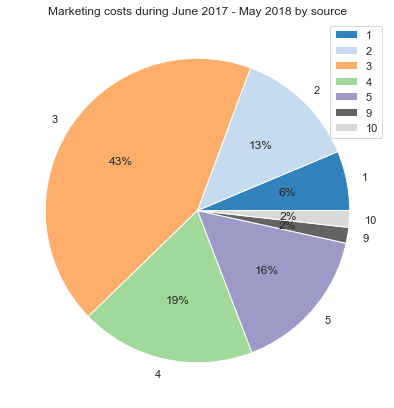

In [66]:
print('Total marketing costs during June 2017 - May 2018: {}'.format(costs['costs'].sum()))

costs_by_source = costs.pivot_table(index='source_id',
                        values='costs',
                        aggfunc='sum')

costs_by_source.plot(kind='pie', y='costs', figsize=(15,7), autopct='%1.0f%%', cmap='tab20c')
plt.title('Marketing costs during June 2017 - May 2018 by source')
plt.ylabel('')
plt.show()

The largest amount of expenses in June 2017 - May 2018 fell on the 3rd source, followed by 4th, 5th and 2nd sources.

Let's analyze the dynamics of marketing expenses during the year.

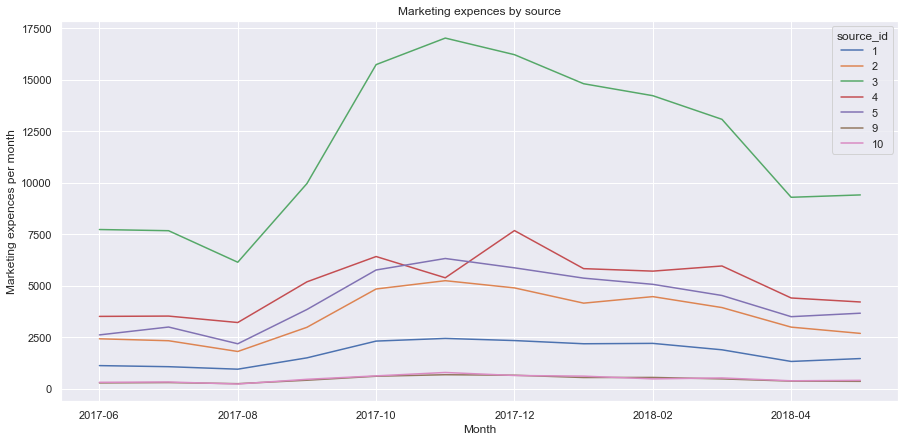

In [68]:
sns.set_style('darkgrid')
costs['dt_month'] = (
    costs['dt']
    .astype('datetime64[M]')
    .dt.strftime('%Y-%m')
)

costs.pivot_table(index='dt_month',
                  columns='source_id',
                  values='costs',
                  aggfunc='sum').plot(kind='line',
                                       figsize=(15,7))

plt.title('Marketing expences by source')
plt.ylabel('Marketing expences per month')
plt.xlabel('Month')
plt.show()

Marketing spending increases in autumn 2017 and decreases in spring 2018, which may be due to seasonality. Spending on the main 3 source increases most significantly in winter. 

Let's analyze how much it costs to attract one customer from each source, and compare this with the revenue from one customer who came to the site from this source.

In [69]:
buyers_by_source = (
    (
        orders
        .groupby('first_source_id')['uid']
        .nunique()
    )
    .reset_index()
    .rename(columns={'first_source_id':'source_id'})
)

buyers_by_source['source_id'] = buyers_by_source['source_id'].astype('int')

costs_by_source = pd.merge(costs_by_source, 
                           buyers_by_source, 
                           on='source_id', 
                           how='left')

costs_by_source['costs_per_uid'] = costs_by_source['costs']/costs_by_source['uid']
costs_by_source = costs_by_source.set_index('source_id')

revenue_by_source = (
    (
        orders
        .groupby('first_source_id')['revenue']
        .sum()
    )
    .reset_index()
    .rename(columns={'first_source_id':'source_id'})
)

revenue_by_source['source_id'] = revenue_by_source['source_id'].astype('int')

costs_by_source = (
    pd.merge(
        costs_by_source,
        revenue_by_source,
        how='left',
        on= 'source_id')
    .set_index('source_id')
)

costs_by_source['revenue_per_uid'] = costs_by_source['revenue']/costs_by_source['uid']

print('Marketing costs and revenue per user by marketing source')
display(costs_by_source)

Marketing costs and revenue per user by marketing source


costs   uid  costs_per_uid   revenue  revenue_per_uid
source_id                                                           
1           20833.27  2914           7.15  23683.70             8.13
2           42806.04  3420          12.52  29801.64             8.71
3          141321.63  9937          14.22  46248.97             4.65
4           61073.60  9833           6.21  49208.54             5.00
5           51757.10  6724           7.70  40355.47             6.00
9            5517.49  1055           5.23   5391.25             5.11
10           5822.49  1276           4.56   4495.22             3.52

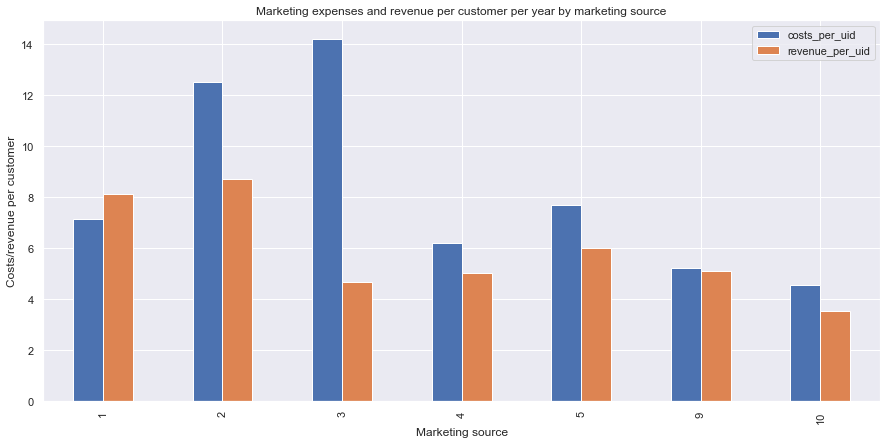

In [70]:
costs_by_source[['costs_per_uid', 'revenue_per_uid']].plot(kind='bar',
                                                           figsize=(15,7))

plt.title('Marketing expenses and revenue per customer per year by marketing source')
plt.xlabel('Marketing source')
plt.ylabel('Costs/revenue per customer')
plt.show()

On average, the cost of attracting one customer exceeds the profit received from it, for all advertising sources, except for source 1.

Let's calculate **LTV** and **CAC** (customer acquisition cost) by cohort. Let's calculate **ROMI** (return on marketing investments).

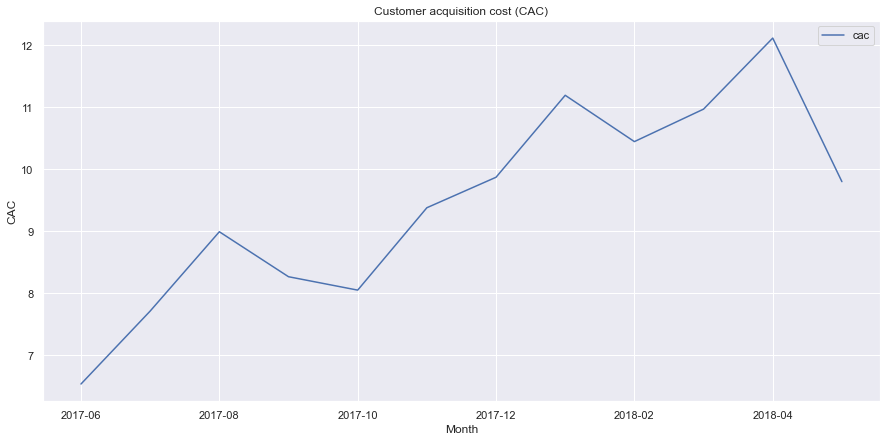

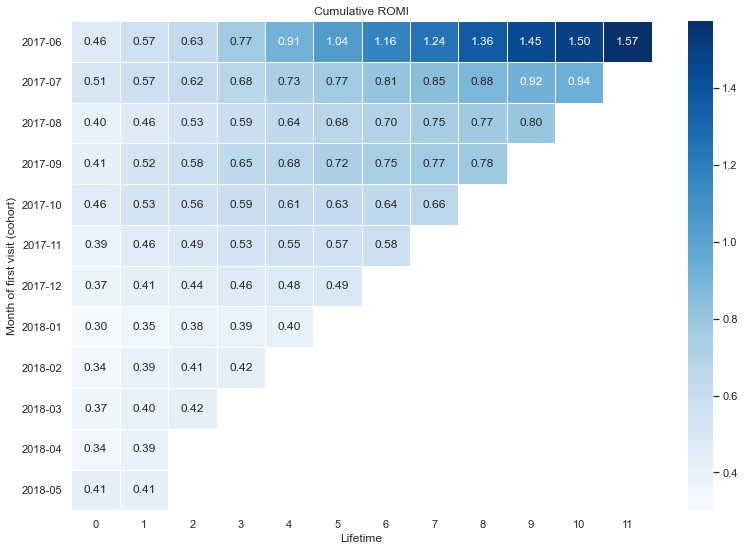

Cumulative ROMI of an average cohort


cohort_lifetime    0     1     2     3     4     5     6     7     8     9   \
ROMI             0.40  0.46  0.51  0.56  0.63  0.70  0.77  0.85  0.95  1.06   

cohort_lifetime    10    11  
ROMI             1.22  1.57

In [71]:
cohort_sizes = (
    (
        orders
        .groupby('first_visit_month')
        .agg({'uid': 'nunique'})
    )
    .reset_index()
)

cohort_sizes.columns = ['first_visit_month', 'n_buyers']

margin_rate = 1

cohorts = (
    (
        orders
        .groupby(['first_visit_month','cohort_lifetime'])
        .agg({'revenue': 'sum'})
    )
    .reset_index()
)

report = pd.merge(cohort_sizes, 
                  cohorts, 
                  on='first_visit_month')

report['gp'] =  report['revenue'] * margin_rate
report['ltv'] = report['gp'] / report['n_buyers']
report['first_visit_month'] = report['first_visit_month'].dt.strftime('%Y-%m')

monthly_costs = (
    (
    costs
    .groupby('dt_month')['costs']
    .sum()
    )
    .reset_index()
)

report_new = pd.merge(report, 
                      monthly_costs, 
                      left_on='first_visit_month', 
                      right_on='dt_month')

report_new['cac'] = report_new['costs'] / report_new['n_buyers']

report_new['romi'] = report_new['ltv'] / report_new['cac']

result_cac = (
    report_new
    .pivot_table(index='first_visit_month', 
                 values='cac',
                 aggfunc='mean')
)

result_cac.plot(kind='line',
                figsize=(15,7))
plt.title('Customer acquisition cost (CAC)')
plt.xlabel('Month')
plt.ylabel('CAC')
plt.show()

result_romi = (
    report_new
    .pivot_table(index='first_visit_month', 
                 columns='cohort_lifetime', 
                 values='romi', 
                 aggfunc='mean')
    .cumsum(axis=1)
)

sns.set(style='white')
plt.figure(figsize=(13, 9))
sns.heatmap(result_romi, annot=True, fmt='.2f', linewidths=1, linecolor='white', cmap="Blues")
plt.title('Cumulative ROMI')
plt.xlabel('Lifetime')
plt.ylabel('Month of first visit (cohort)')
plt.yticks(rotation=0)
plt.show()

print('Cumulative ROMI of an average cohort')
display(
    (
        result_romi
        .mean(axis=0)
    )
    .reset_index()
    .set_index('cohort_lifetime')
    .rename(columns={0:'ROMI'})
    .T
)

On average, cohorts pay off by the end of the 10th month. At the same time, the June 2017 cohort paid off much faster than the others: as soon as by the end of 6 months. The July cohort did not pay off even by the end of the 11th month, each subsequent cohort pays off even more slowly. The effectiveness of marketing spending is declining every month. Let's analyze ROMI by marketing source.

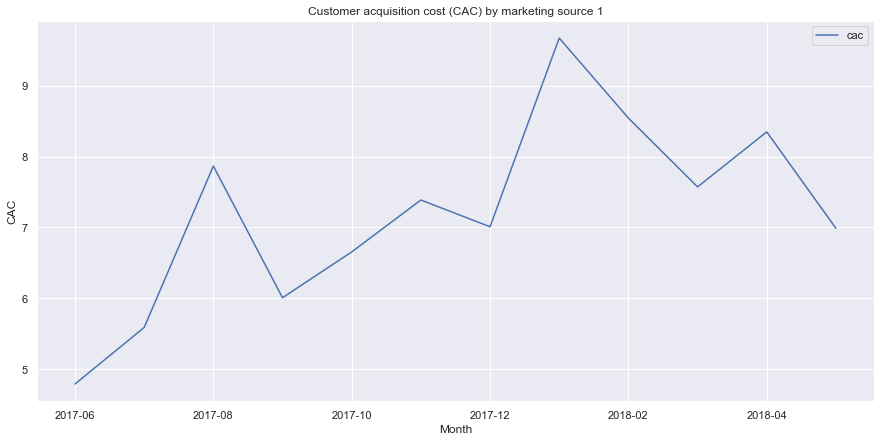

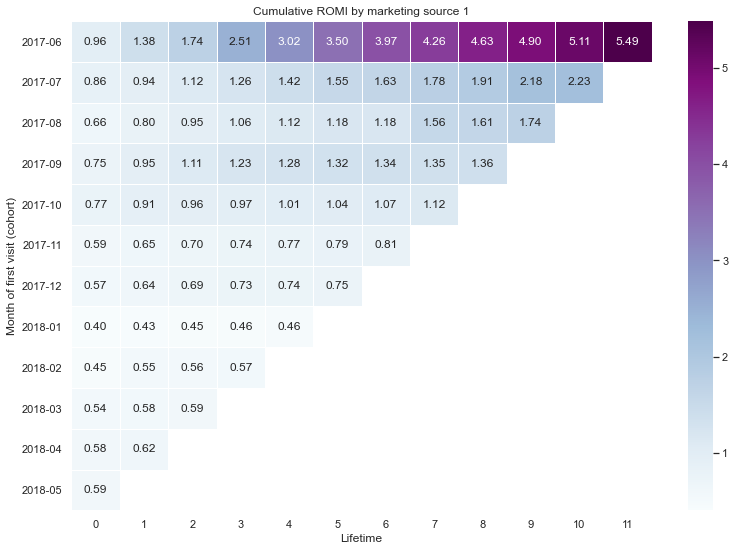

Cumulative ROMI of an average cohort, marketing source 1


cohort_lifetime    0     1     2     3     4     5     6     7     8     9   \
ROMI             0.64  0.77  0.89  1.06  1.23  1.45  1.67  2.02  2.38  2.94   

cohort_lifetime    10    11  
ROMI             3.67  5.49

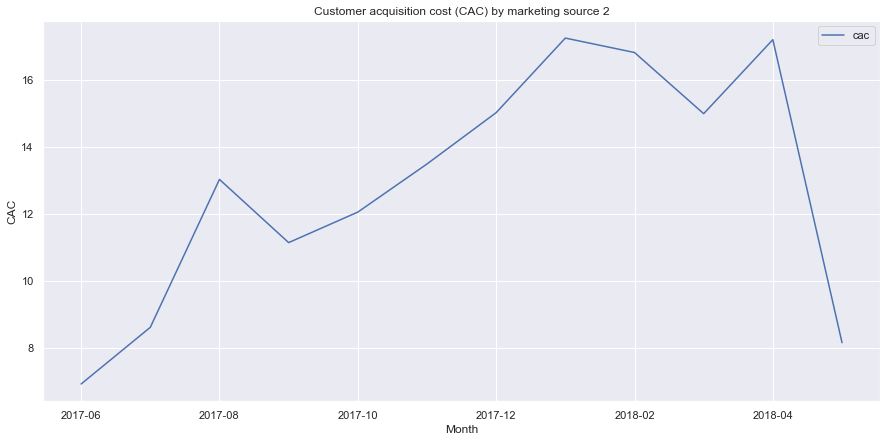

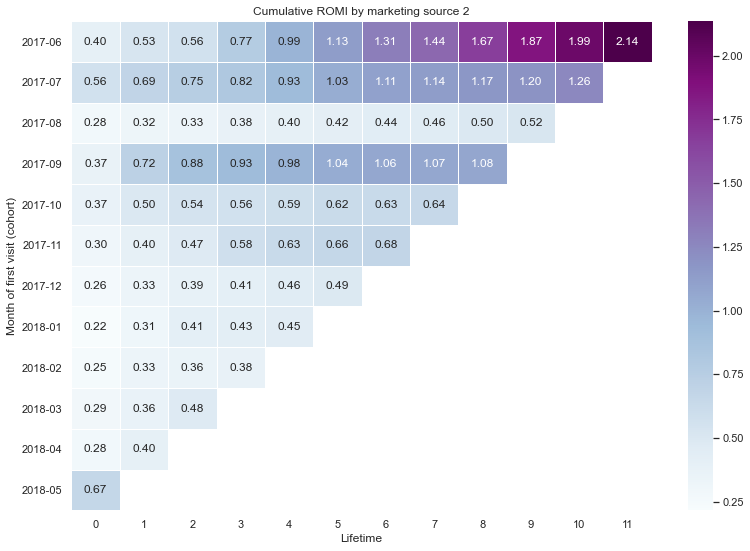

Cumulative ROMI of an average cohort, marketing source 2


cohort_lifetime    0     1     2     3     4     5     6     7     8     9   \
ROMI             0.35  0.44  0.52  0.59  0.68  0.77  0.87  0.95  1.10  1.20   

cohort_lifetime    10    11  
ROMI             1.62  2.14

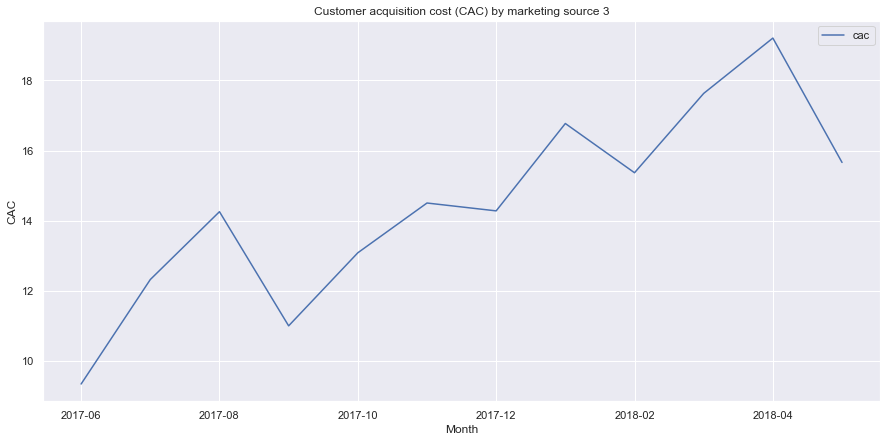

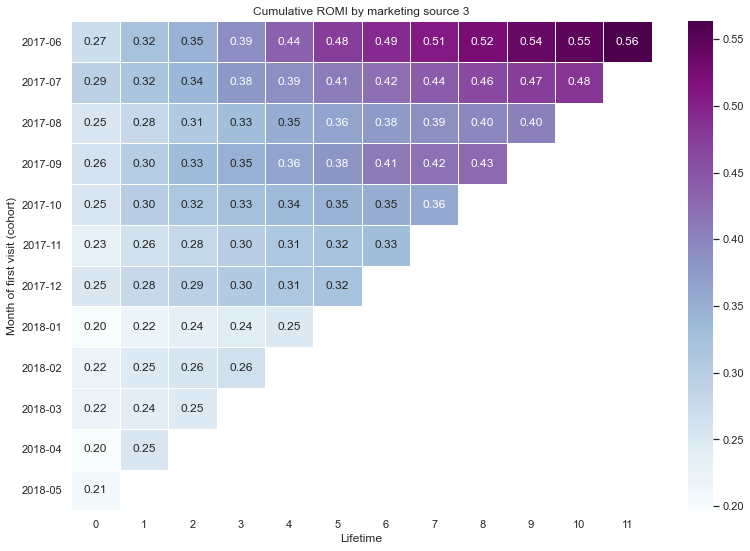

Cumulative ROMI of an average cohort, marketing source 3


cohort_lifetime    0     1     2     3     4     5     6     7     8     9   \
ROMI             0.24  0.27  0.30  0.32  0.34  0.37  0.40  0.42  0.45  0.47   

cohort_lifetime    10    11  
ROMI             0.52  0.56

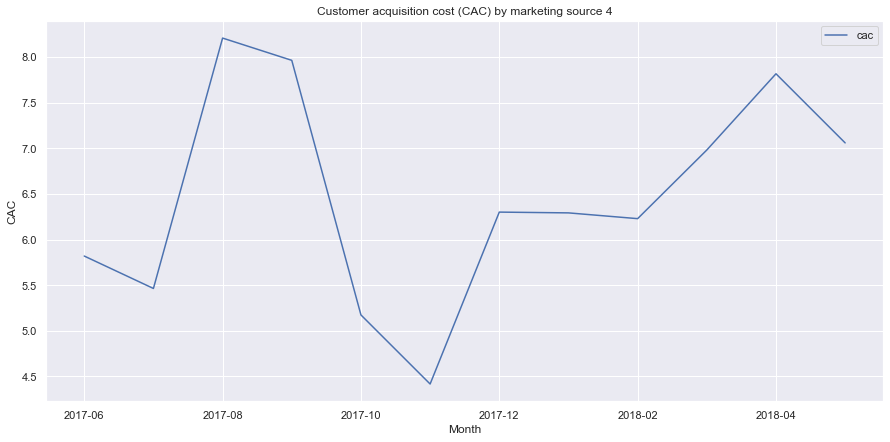

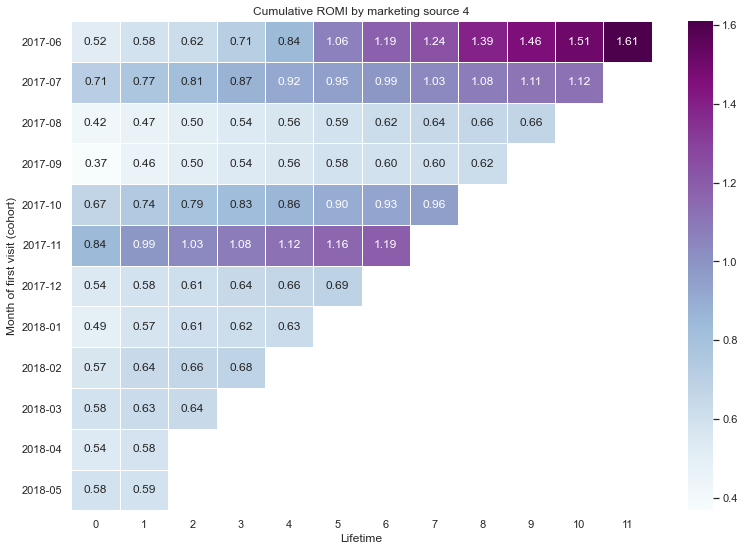

Cumulative ROMI of an average cohort, marketing source 4


cohort_lifetime    0     1     2     3     4     5     6     7     8     9   \
ROMI             0.57  0.63  0.68  0.72  0.77  0.85  0.92  0.89  0.94  1.08   

cohort_lifetime    10    11  
ROMI             1.32  1.61

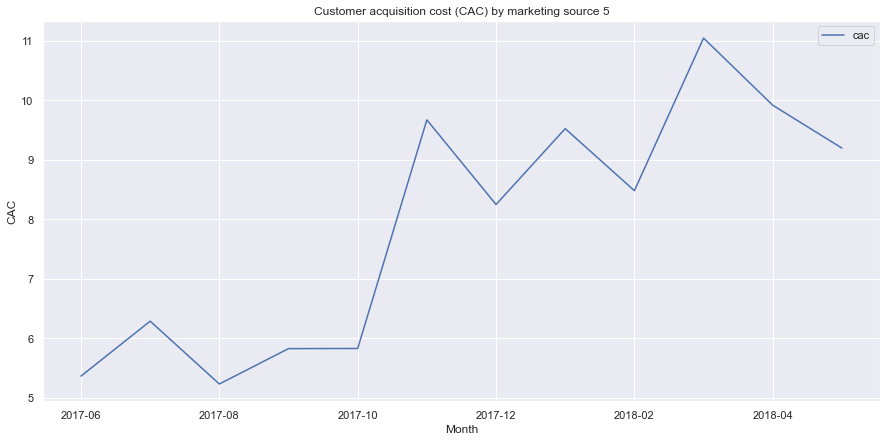

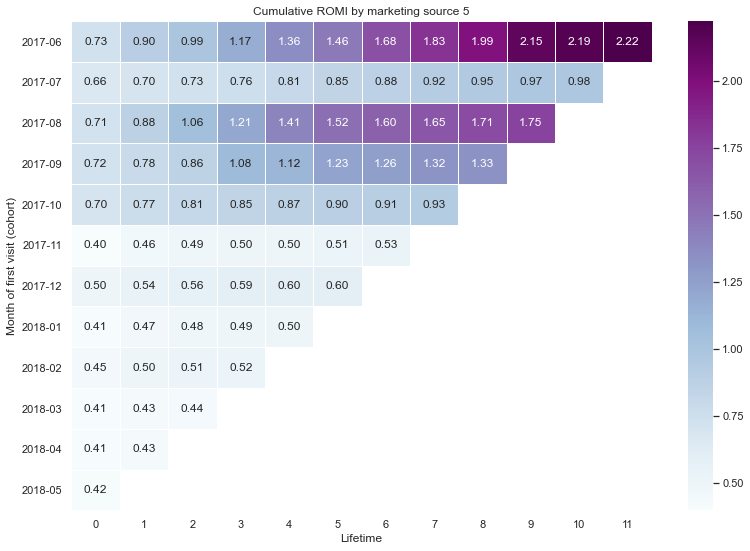

Cumulative ROMI of an average cohort, marketing source 5


cohort_lifetime    0     1     2     3     4     5     6     7     8     9   \
ROMI             0.54  0.62  0.69  0.80  0.90  1.01  1.14  1.33  1.50  1.62   

cohort_lifetime    10    11  
ROMI             1.59  2.22

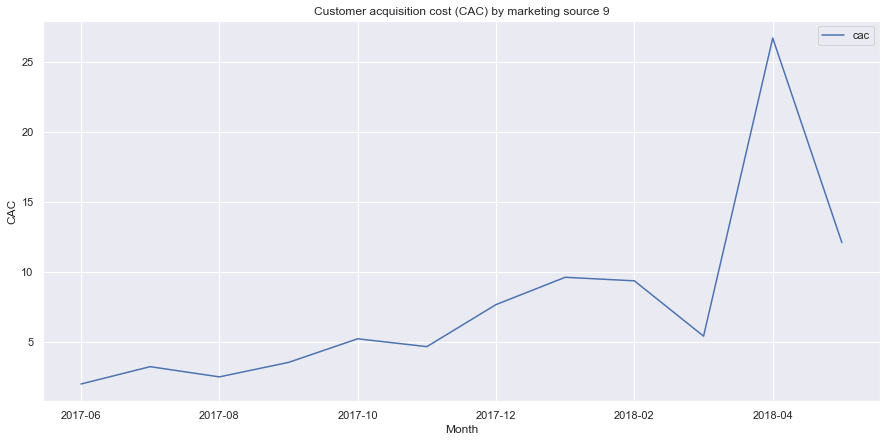

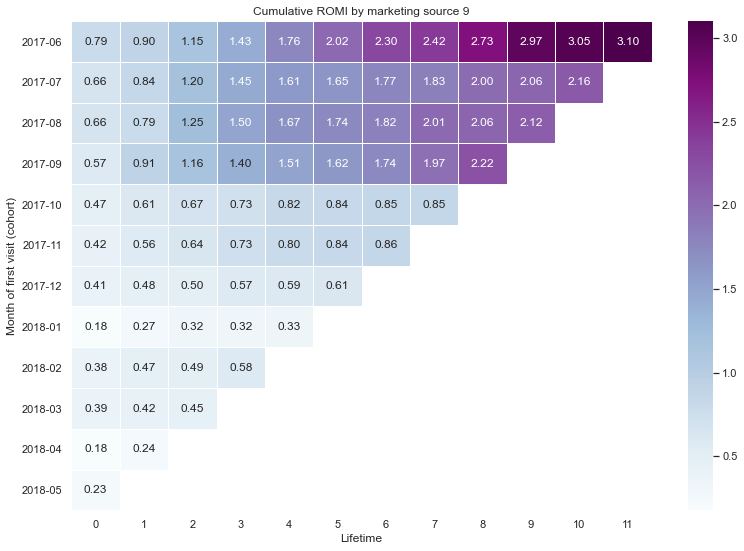

Cumulative ROMI of an average cohort, marketing source 9


cohort_lifetime    0     1     2     3     4     5     6     7     8     9   \
ROMI             0.45  0.59  0.78  0.97  1.14  1.33  1.56  1.82  2.25  2.38   

cohort_lifetime    10    11  
ROMI             2.60  3.10

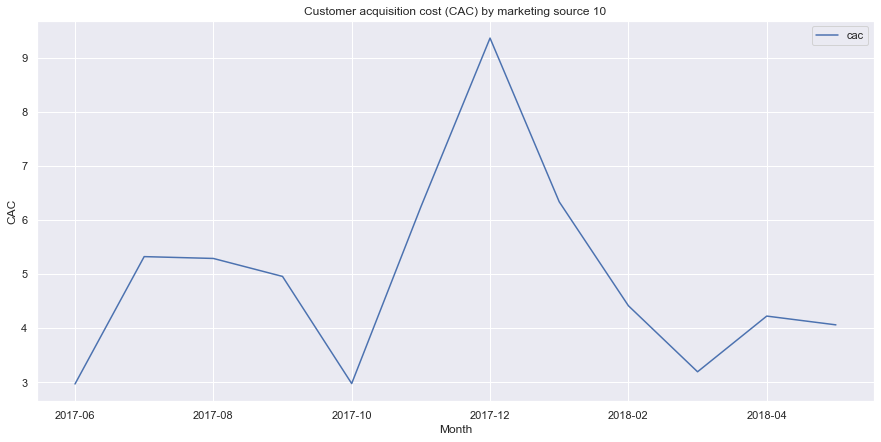

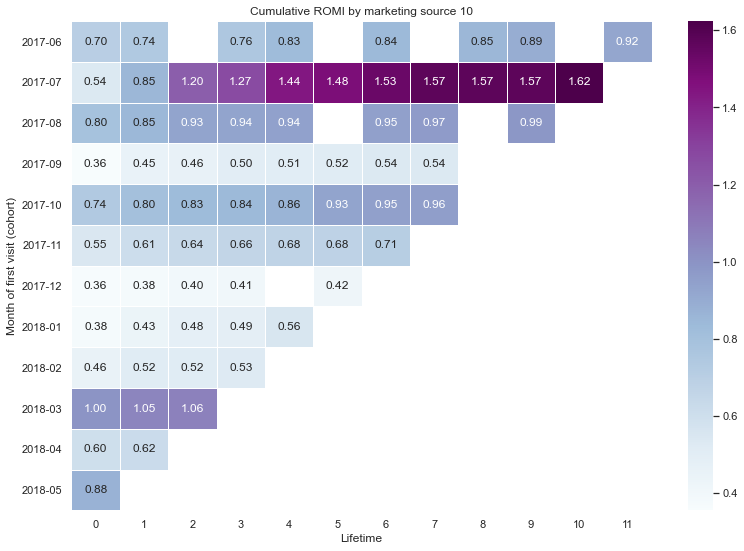

Cumulative ROMI of an average cohort, marketing source 10


cohort_lifetime    0     1     2     3     4     5     6     7     8     9   \
ROMI             0.61  0.66  0.72  0.71  0.83  0.81  0.92  1.01  1.21  1.15   

cohort_lifetime    10    11  
ROMI             1.62  0.92

In [72]:
sns.set(style='darkgrid')
for source in sources:
    cohort_sizes = (
        (
            orders[orders['first_source_id'] == source]
            .groupby('first_visit_month')
            .agg({'uid': 'nunique'})
        )
        .reset_index()
    )
    cohort_sizes.columns = ['first_visit_month', 'n_buyers']
    margin_rate = 1
    cohorts = (
        (
            orders[orders['first_source_id'] == source]
            .groupby(['first_visit_month','cohort_lifetime'])
            .agg({'revenue': 'sum'})
        )
        .reset_index()
    )
    report = pd.merge(cohort_sizes, 
                  cohorts, 
                  on='first_visit_month')
    report['gp'] =  report['revenue'] * margin_rate
    report['ltv'] = report['gp'] / report['n_buyers']
    report['first_visit_month'] = report['first_visit_month'].dt.strftime('%Y-%m')
    monthly_costs = (
        (
        costs[costs['source_id'] == source]
        .groupby('dt_month')['costs']
        .sum()
        )
        .reset_index()
    )
    report_new = pd.merge(report, 
                          monthly_costs, 
                          left_on='first_visit_month', 
                          right_on='dt_month')
    report_new['cac'] = report_new['costs'] / report_new['n_buyers']
    report_new['romi'] = report_new['ltv'] / report_new['cac']
    result_cac = report_new.pivot_table(index='first_visit_month', 
                                        values='cac',
                                        aggfunc='mean')
    result_cac.plot(kind='line', figsize=(15,7))
    plt.title('Customer acquisition cost (CAC) by marketing source {}'.format(source))
    plt.xlabel('Month')
    plt.ylabel('CAC')
    plt.show()
    result_romi = (
        report_new
        .pivot_table(index='first_visit_month',
                     columns='cohort_lifetime',
                     values='romi',
                     aggfunc='mean')
        .cumsum(axis=1)
    )
    sns.set(style='white')
    plt.figure(figsize=(13, 9))
    sns.heatmap(result_romi, annot=True, fmt='.2f', linewidths=1, linecolor='white', cmap="BuPu")
    plt.title('Cumulative ROMI by marketing source {}'.format(source))
    plt.xlabel('Lifetime')
    plt.ylabel('Month of first visit (cohort)')
    plt.yticks(rotation=0)
    plt.show()
    print('Cumulative ROMI of an average cohort, marketing source {}'.format(source))
    display(result_romi.mean(axis=0).reset_index().set_index('cohort_lifetime').rename(columns={0:'ROMI'}).T)
    sns.set(style='darkgrid')

Cohorts of users from different marketing sources pay off with different speed and the differences are quite essential.

* Source 1: cohorts pay off on average by the end of 4 months, and the ROMI of the June cohort significantly exceeds the ROMI of the rest.
* Source 2: cohorts on average pay off by the end of the 9th month, and the June, July and September cohorts paid off faster - by the end of the 6th month.
* Source 3: cohorts do not pay off in 12 months, each subsequent cohort pays off more slowly than the previous one.
* Source 4: cohorts pay off on average by the end of the 10th month, while the November cohort paid off by the end of the third month, June cohort paid off by the end of the sixth, and July cohort paid off by the end of the eighth month.
* Source 5: cohorts on average pay off by the end of the 6th month, and the August cohort paid off by the end of the third month, and the June and September cohort  payed off by the end of the 4th month.
* Source 9: cohorts on average pay off by the end of 4 months, while if the first four cohorts paid off by the end of 3 months, then all subsequent ones did not pay off during the analyzed period.
* Source 10: cohorts pay off on average by the end of the 8th month, while the March cohort paid off already in the first month, and the September cohort paid off by the end of the third month. 

### Conclusion for the Marketing section

* Total marketing spend in June 2017 - May 2018 amounted to 329,132, most of all was spent on 3, 4 and 2 sources. 
* On average the cost of attracting one customer exceeds the profit received from a customer per year, for all marketing sources, except for source 1.
* On average, cohorts pay off by the end of the 10th month. Each subsequent cohort pays off more slowly than the previous one.
* Source 1 and 9 cohorts pay off fastest, and source 3 cohorts are the slowest. 

## Recomendations <a id="3"></a>   
</div>

* Currently, the largest amount of funds is spent on source 3. Despite the fact that these costs do not pay off within a year, they should not be significantly reduced, since for source 3, unlike the others, the payback period of each subsequent cohort is not significantly reduced.
* When planning costs for other sources, seasonality must be taken into account: it is likely that the change in payback for cohorts is associated with it.
* It is advisable to increase expenses (seasonally adjusted) for source 4, the payback period for each subsequent cohort also does not decrease significantly, the largest number of users get to the site from this source.